In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from load_and_clean import *
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

import numpy as np
import pandas as pd

from tslib.src import tsUtils
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

%matplotlib inline
from filter_data import *
from syn_model import *

import warnings
warnings.filterwarnings("ignore")

from pyod.models.hbos import HBOS
from itertools import product
import datetime
import random

In [3]:

delta_variant_data = {'France': '2021-02-21',
                     'Ireland': '2021-02-26',
                     'Germany': '2021-03-01',
                     'Denmark': '2021-03-08',
                     'Belgium': '2021-03-25',
                     'Sweden': '2021-03-26',
                     'Switzerland': '2021-03-29',
                     'Italy': '2021-04-02',
                     'Portugal': '2021-04-05',
                     'Norway': '2021-04-06',
                     'United Kingdom': '2021-02-22',
                     'Finland': '2021-03-18',
                      'Korea, South': '2021-03-26',
                      'Japan': '2021-03-28',
                      'Netherlands': '2021-04-06',
                      'Luxembourg': '2021-04-15',
                      'Austria': '2021-04-17',
                      'Slovenia': '2021-04-20',
                      'Russia': '2021-04-21',
                      'US': '2021-02-23',
                      'Spain': '2021-04-22',
                      'Czechia': '2021-04-24',
                      'Poland': '2021-04-26',
                      'Turkey': '2021-04-28'
                     }


delta_variant_data = pd.DataFrame(delta_variant_data, index = ["Date"]).T
#delta_variant_data["Date"] = pd.to_datetime(delta_variant_data['Date'])
### Netherland
# target = "Netherlands"
# tick_spacing = 90

# donors = ["France", "Ireland", "Germany", "Denmark", "Belgium",
#          "Sweden", "Switzerland", "Italy", "Portugal", 
#          "Norway", "United Kingdom"]

# donor_start = ["2021-02-21", "2021-02-26", "2021-03-01", "2021-03-08", "2021-03-25", 
#                "2021-03-26", "2021-03-29", "2021-04-02", "2021-04-05", 
#                "2021-04-06", "2021-04-05", "2021-02-22"]

# target_start = "2021-04-06"

## Import data

In [4]:

#update_data()

#us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
# mobility_data_apple = load_clean('mobility Apple')
# mobility_data_google, google_social = load_clean('mobility Google')
# sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True)

# state_reopen = load_clean('state reopen')
# #fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

# ctp_us_data = load_clean('CTP US')
# ctp_state_data = load_clean('CTP states')
# ctp_state_pop_adjusted = {stat: create_population_adjusted_data(data, all_population, show_exception=False) for stat, data in ctp_state_data.items()}

These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Burma', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'MS Zaandam', 'Micronesia', 'North Macedonia', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Summer Olympics 2020', 'Syria', 'Taiwan*', 'West Bank and Gaza']
These countries/region do not have population data ['Adjuntas-Puerto Rico', 'Aguada-Puerto Rico', 'Aguadilla-Puerto Rico', 'Aguas Buenas-Puerto Rico', 'Aibonito-Puerto Rico', 'Anasco-Puerto Rico', 'Anchorage-Alaska', 'Arecibo-Puerto Rico', 'Arroyo-Puerto Rico', 'Barceloneta-Puerto Rico', 'Barranquitas-Puerto Rico', 'Bayamon-Puerto Rico', 'Bristol Bay plus Lake and Peninsula-Alaska', 'Cabo Rojo-Puerto Rico', 'Caguas-Puerto Rico', 'Camuy-Puerto Rico', 'Canovanas-Puerto Rico', 'Carolina-Puerto Rico', 'Catano-Puer

In [5]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
#column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
#educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

# _, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
# _, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
# _, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

# cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
# deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)
#deaths_intervention_adjusted_google, deaths_intervention_adjusted_daily_google, _ = create_intervention_adjusted_data(all_data, google_social, t)

# all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
# all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

# hospitalized_pop_adjusted, hospitalized_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['hospitalizedCurrently'], educational_distancing, t, ignore_nan=True)
# icu_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['inIcuCurrently'], educational_distancing, t, ignore_nan=True)
# ventilator_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['onVentilatorCurrently'], educational_distancing, t, ignore_nan=True)


## Mask Mandate for Delta

### Clean the the dataframe about government policy

In [10]:
gov_data = pd.read_excel("COVID_scores.xlsx")
gov_data['DATE'] = pd.to_datetime(gov_data['DATE'])
gov_data = gov_data[['STATE', "DATE", "CATEGORY5"]]
gov_data = gov_data.dropna()
gov_data["CATEGORY5"] = gov_data.dropna().groupby(by = ["STATE"]).cumsum()["CATEGORY5"]
min_date = np.min(gov_data.DATE)
max_date = np.max(gov_data.DATE)

date_df = pd.DataFrame(pd.date_range(start = min_date, end= max_date), columns = ["DATE"]).values.flatten()
state_df = pd.DataFrame(pd.unique(gov_data.STATE), columns = ["STATE"]).values.flatten()
temp_df = pd.DataFrame(list(product(state_df, date_df)), columns=['STATE', 'DATE'])

df = pd.merge(temp_df, gov_data, how = "outer")
mask_df = pd.pivot_table(df, values="CATEGORY5", index="DATE", columns="STATE", dropna = False)
mask_df.iloc[0] = 0
mask_df = mask_df.fillna(method="ffill")
mask_df.columns = mask_df.columns.map(lambda x: " ".join([w.capitalize() for w in x.split()]))
mask_df.rename(columns = {'District Of Columbia':'District of Columbia'}, inplace = True)

## State Level

- donors: states with mask mandate
- target: states that changes from mask mandate to no mask
- intervention date is the date that policy changes

In [103]:
start_date= "2021-02-23"
singVals = 3
data_df = all_cases_data_pop_daily.loc[start_date:]
data_df = data_df.iloc[:300]

date_range = 100
tick_spacing = 50 

mask_mandate = list(mask_df.columns[np.all(mask_df.loc[start_date:].iloc[:date_range] > 0.5, axis = 0)])
non_mask_mandate = list(mask_df.columns[np.all(mask_df.loc[start_date:].iloc[:date_range] < 0.5, axis = 0)])
policy_change = list(set(mask_df.columns) - set(mask_mandate) - set(non_mask_mandate))

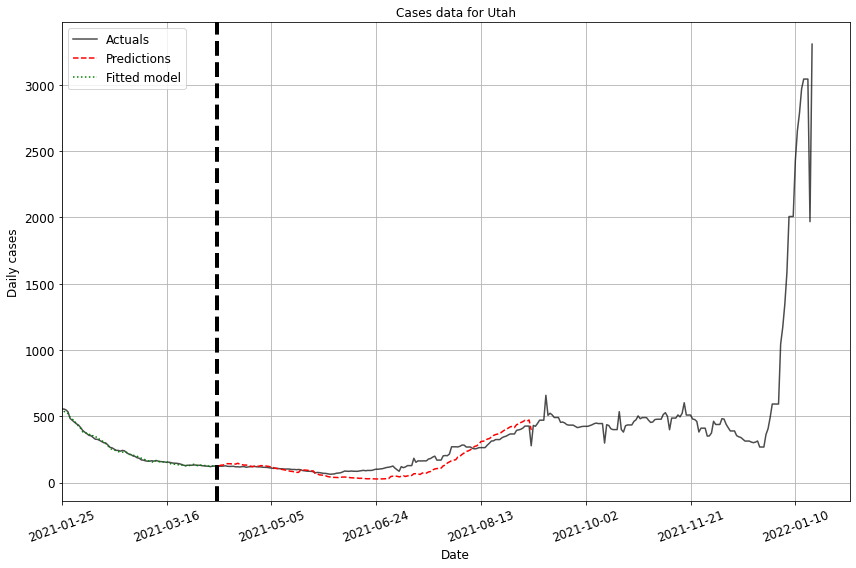

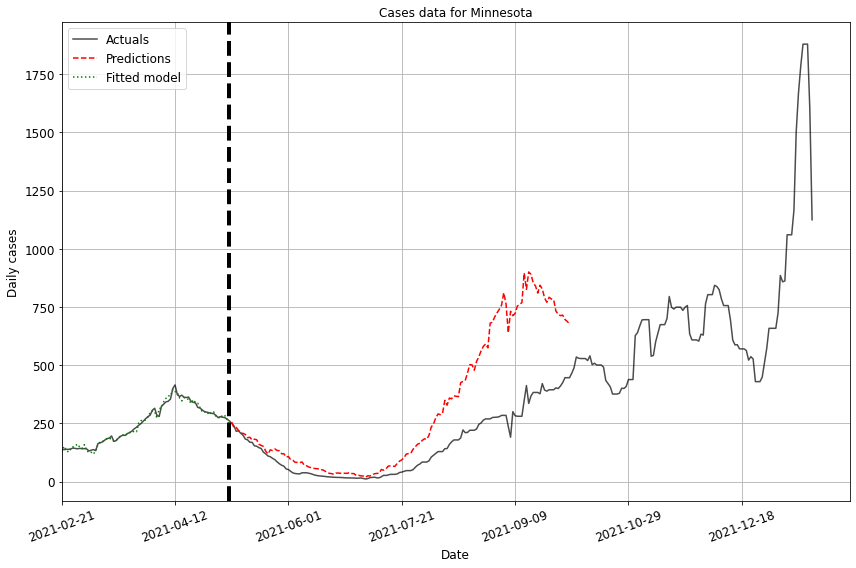

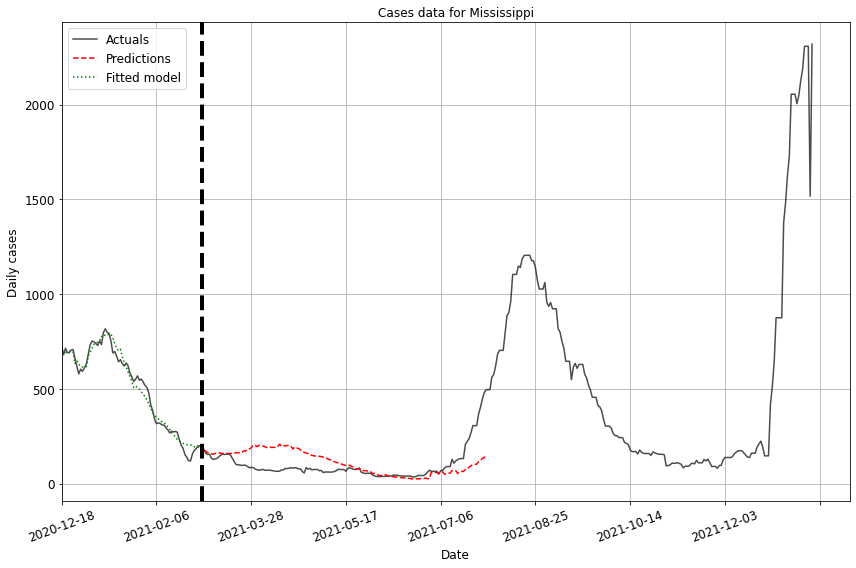

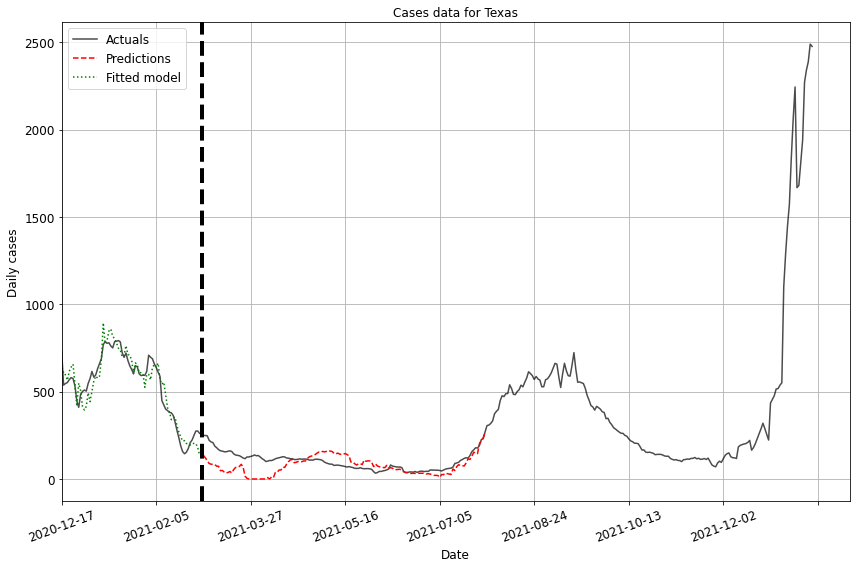

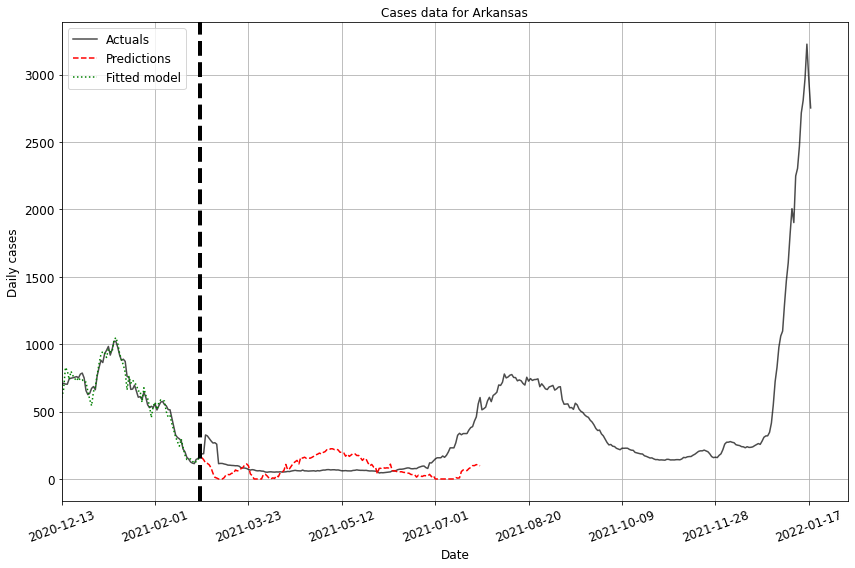

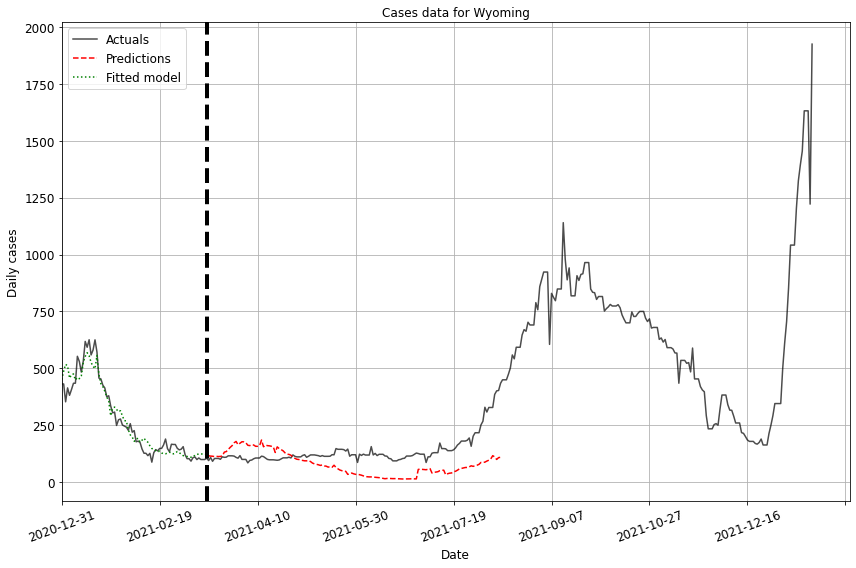

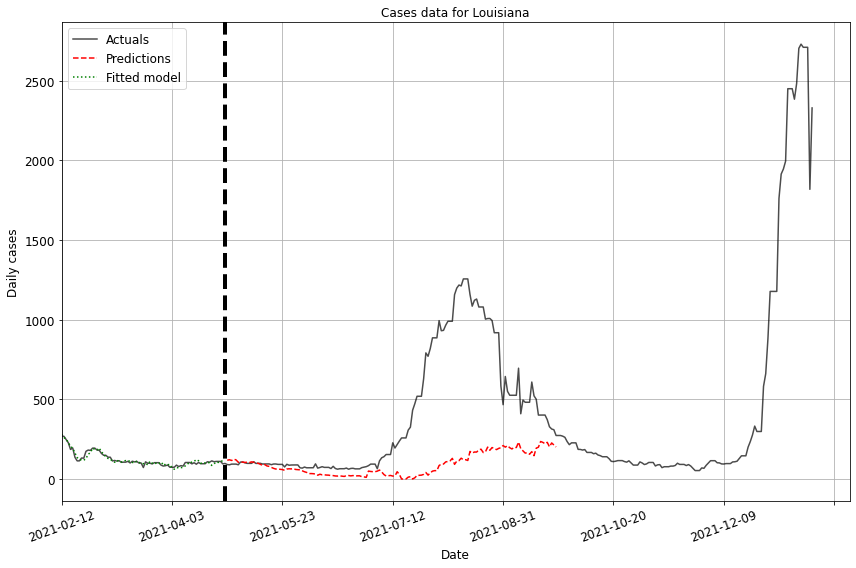

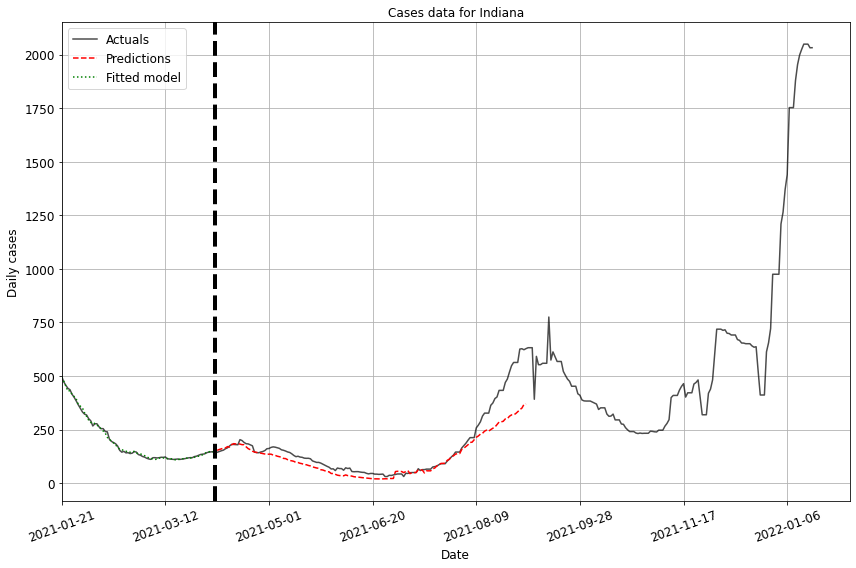

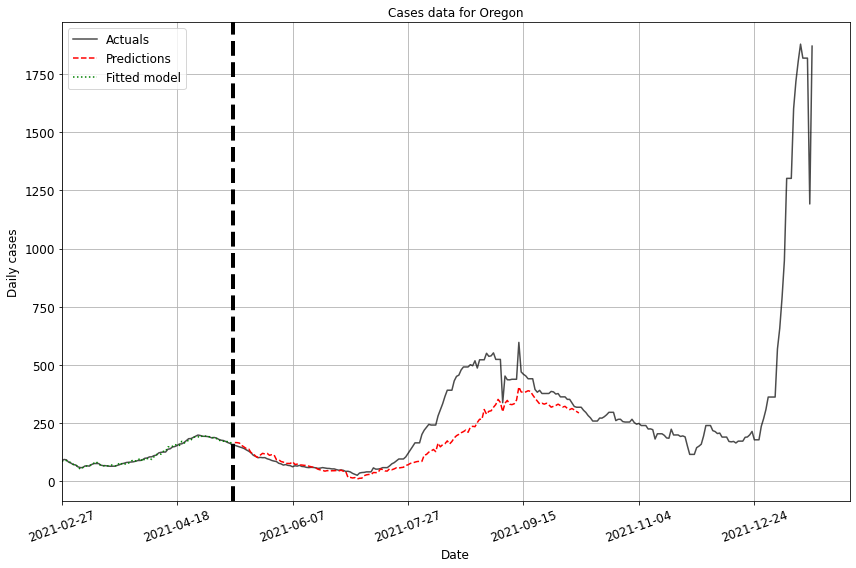

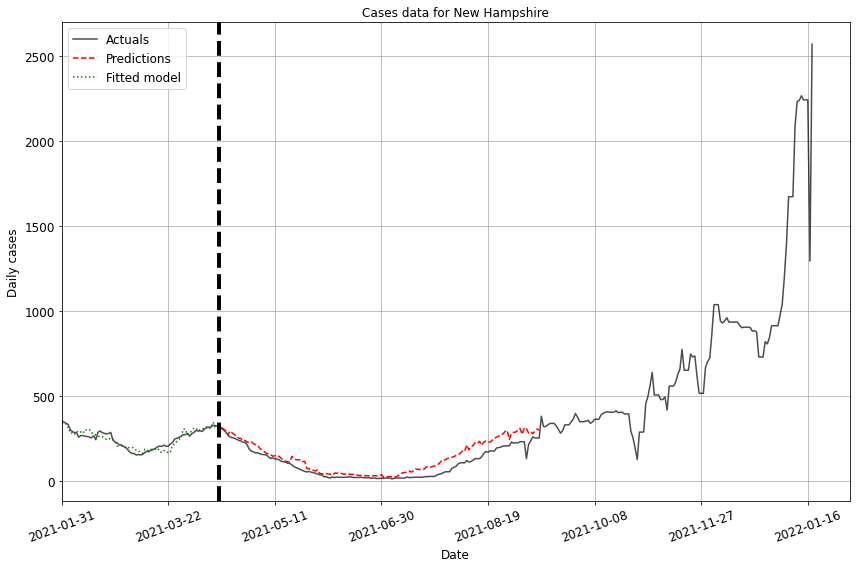

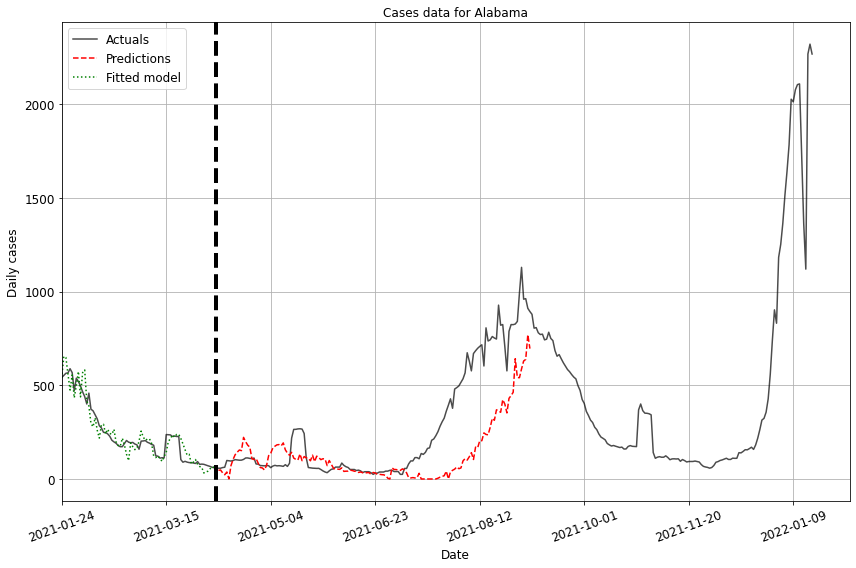

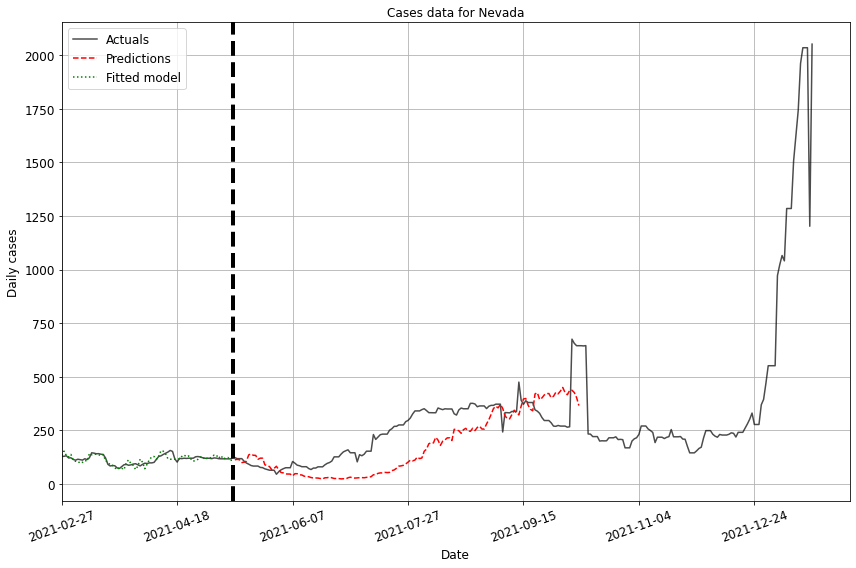

In [90]:
pred_length = 150
sum_actual = np.zeros(pred_length)
sum_pred = np.zeros(pred_length)
low_thresh = 75
for state in policy_change:

    temp = mask_df[state].loc[start_date:].iloc[:date_range]
    temp_idx = mask_df[state].loc[start_date:].iloc[1:date_range].index
    intervention_date = temp_idx[np.diff(temp) != 0][0]
    intervention_date = str(intervention_date.to_pydatetime())[:10]
    
    date_idx = list(all_cases_data_pop_daily.index).index(intervention_date)
    cur_data_df = all_cases_data_pop_daily.iloc[date_idx - low_thresh:]
    
    
#     if intervention_date < 30:
#         continue
#     cur_data_df = data_df.iloc[np.maximum(0, intervention_date - 50):]
    
    rscModel =syn_model(state, singVals, [cur_data_df], low_thresh + pred_length, low_thresh, otherStates = mask_mandate)
    rscModel.fit_model(filter_donor = True, filter_method = 'hbo', singVals_estimate = True, singval_mathod ='auto')

    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
    
    sum_actual += rscModel.actual[rscModel.low_thresh:rscModel.thresh].values 
    sum_pred += predictions

    fig, axes = plt.subplots(1, 1, figsize = (12, 8))

    rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
    #plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
    plt.tight_layout()
    
                                  

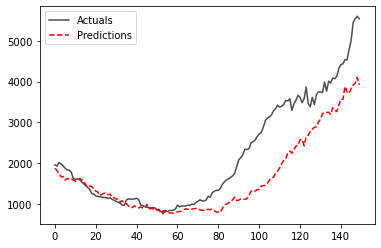

In [91]:
## Aggregate graph
plt.plot(sum_actual, label='Actuals', color='k', linestyle='-', alpha = 0.7)
plt.plot(sum_pred, label='Predictions', color='r', linestyle='--')
plt.legend()
plt.show()

## County Level

In [12]:


donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in mask_mandate and names[0] != 'Unknown':
        donors.append(counties)
        
target_state = "Oregon" #policy_change[3]
print("Use the counties in state " + target_state)

targets = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] == target_state and names[0] != 'Unknown':
        targets.append(counties)
        
        
#targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']#, 'Fulton-Georgia','Gwinnett-Georgia', 'Tarrant-Texas', 'Bexar-Texas','Collin-Texas','Mohave-Arizona','Yuma-Arizona','Maricopa-Arizona', 'Ascension-Louisiana',  'East Carroll-Louisiana']#counties_recommended# ['Ascension-Louisiana', 'Jefferson-Louisiana', 'Bartholomew-Indiana', 'Riverside-California', 'Broward-Florida' ]# #counties_recommended #masks_mandated


NameError: name 'mask_mandate' is not defined

Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties
18
Baker-Oregon 967.3958621345009


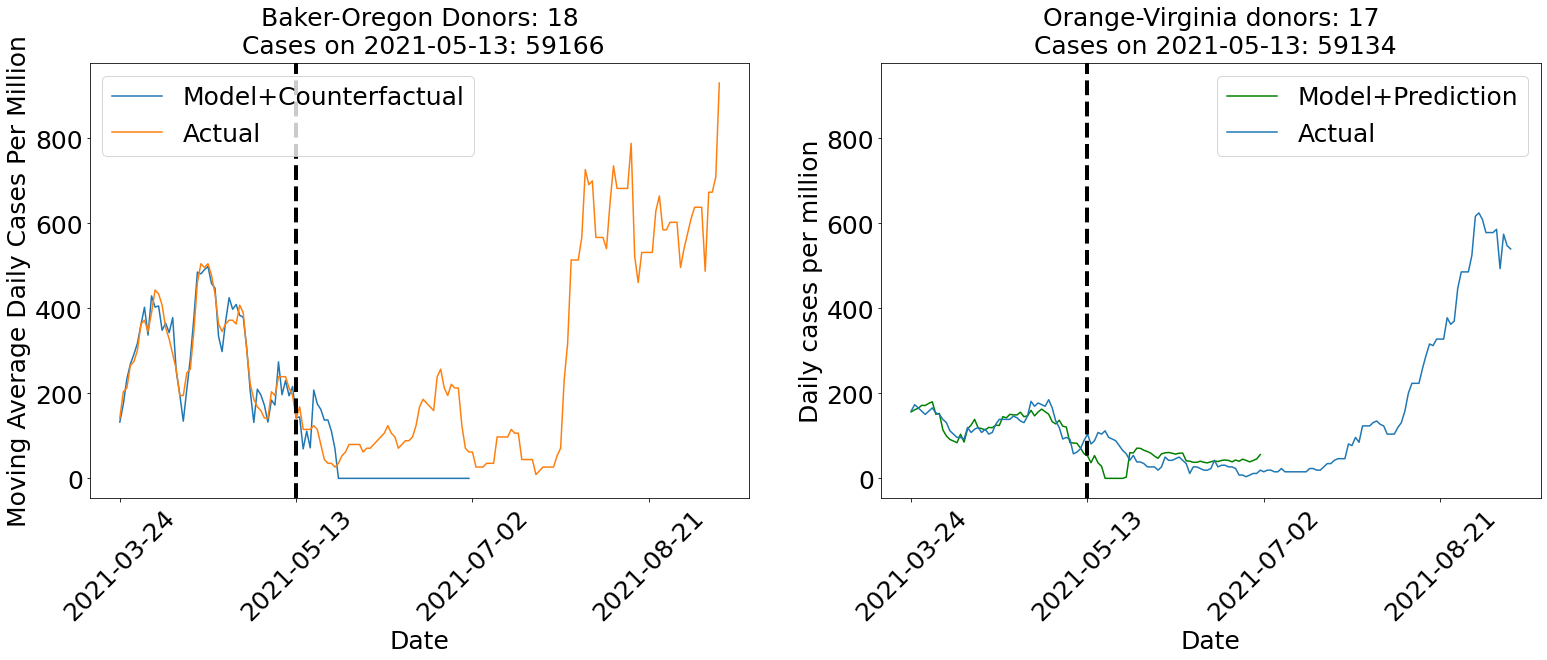

2
2
5
Clackamas-Oregon 1775.948564695369


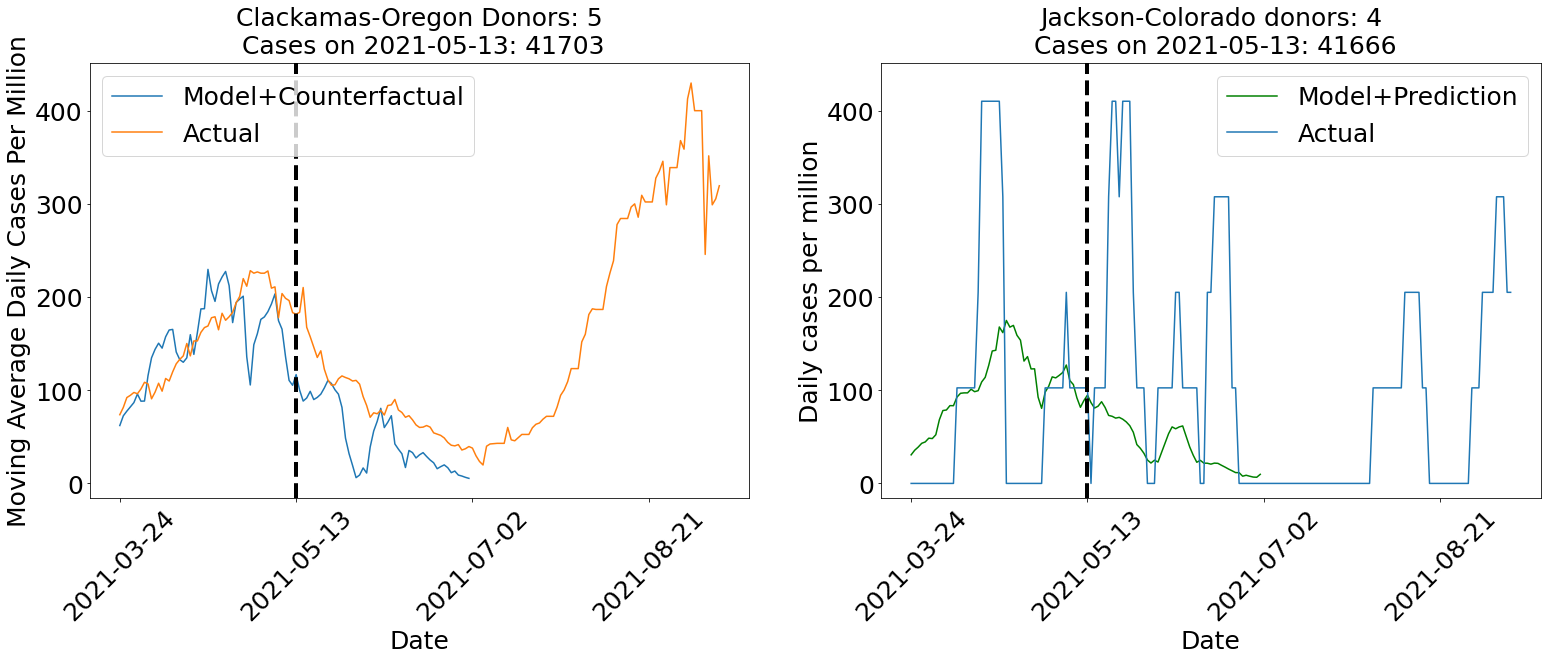

1
1
2
2
3
3
10
Crook-Oregon 4236.092592241527


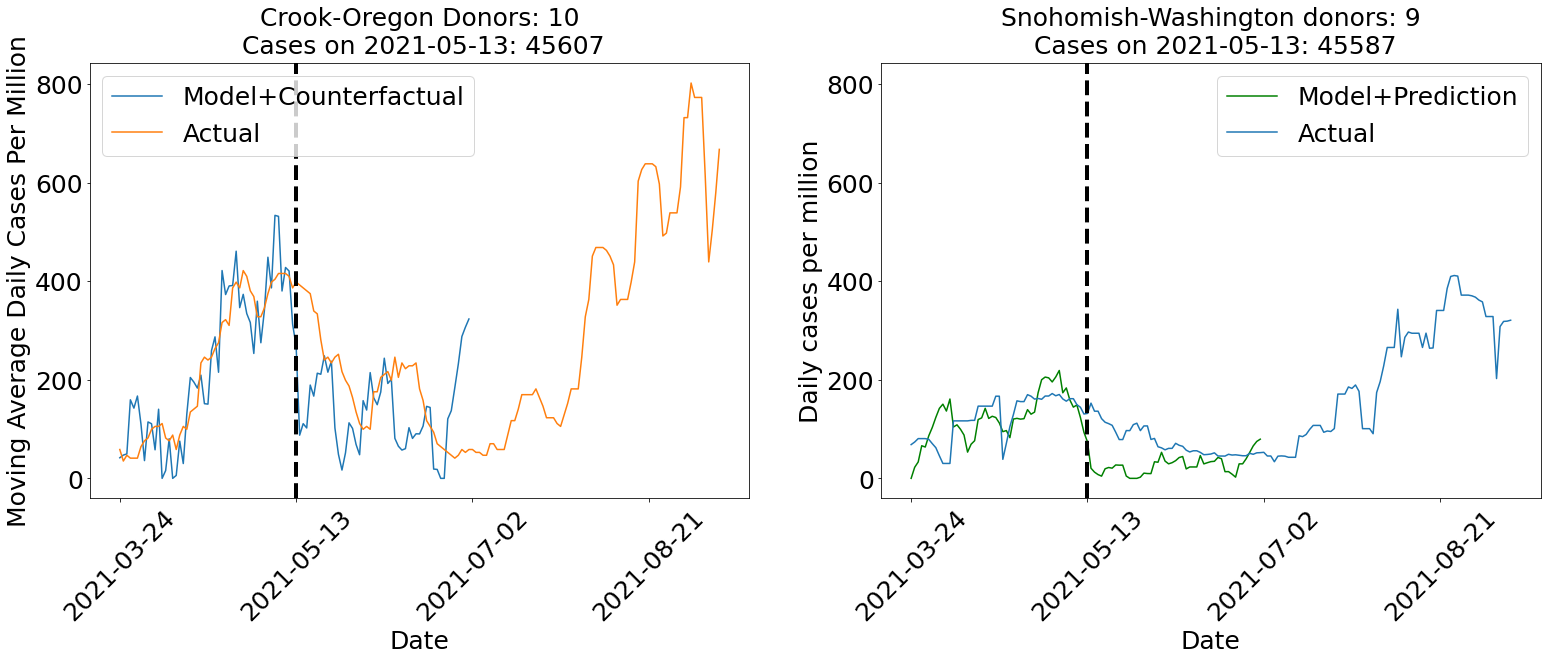

3
3
7
Deschutes-Oregon 2296.15956869331


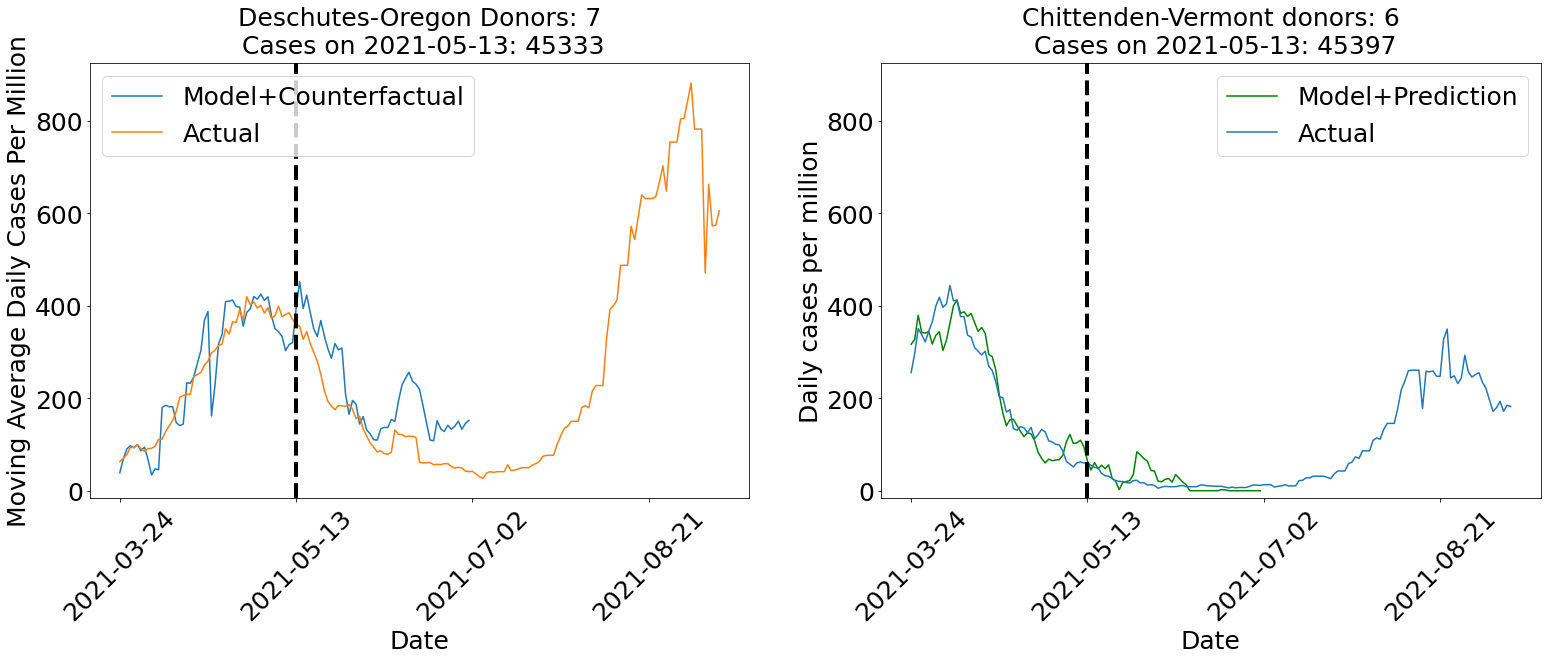

6
Douglas-Oregon 700.2095934768122


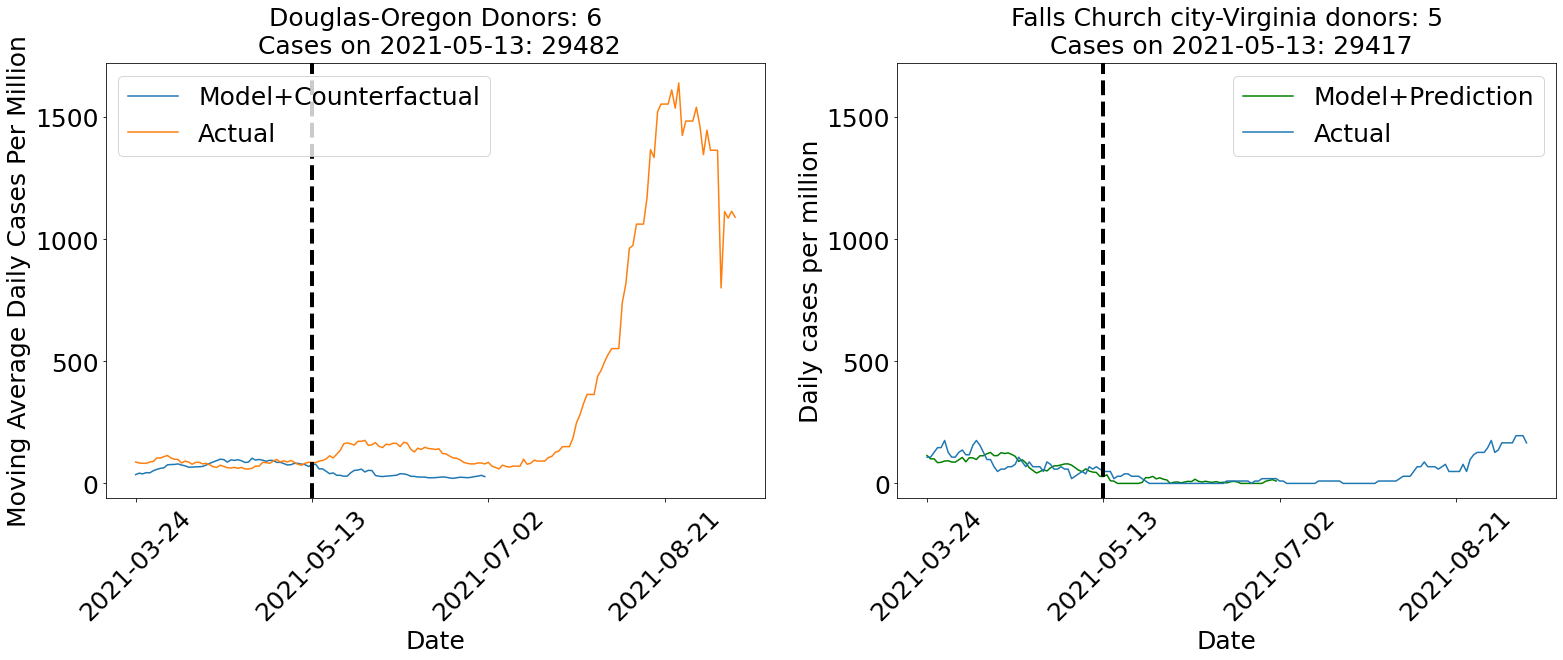

2
2
42
Grant-Oregon 15800.983145990358


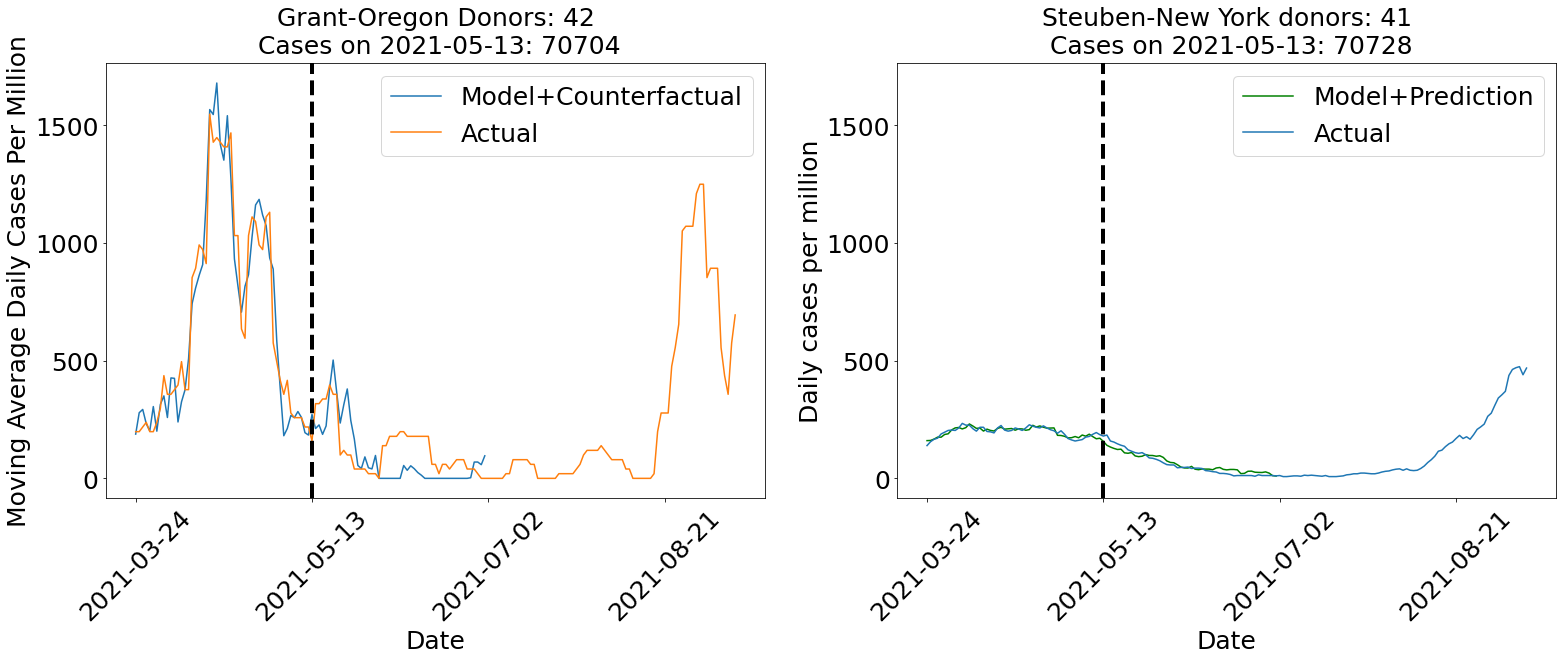

11
Harney-Oregon 890.6636769027036


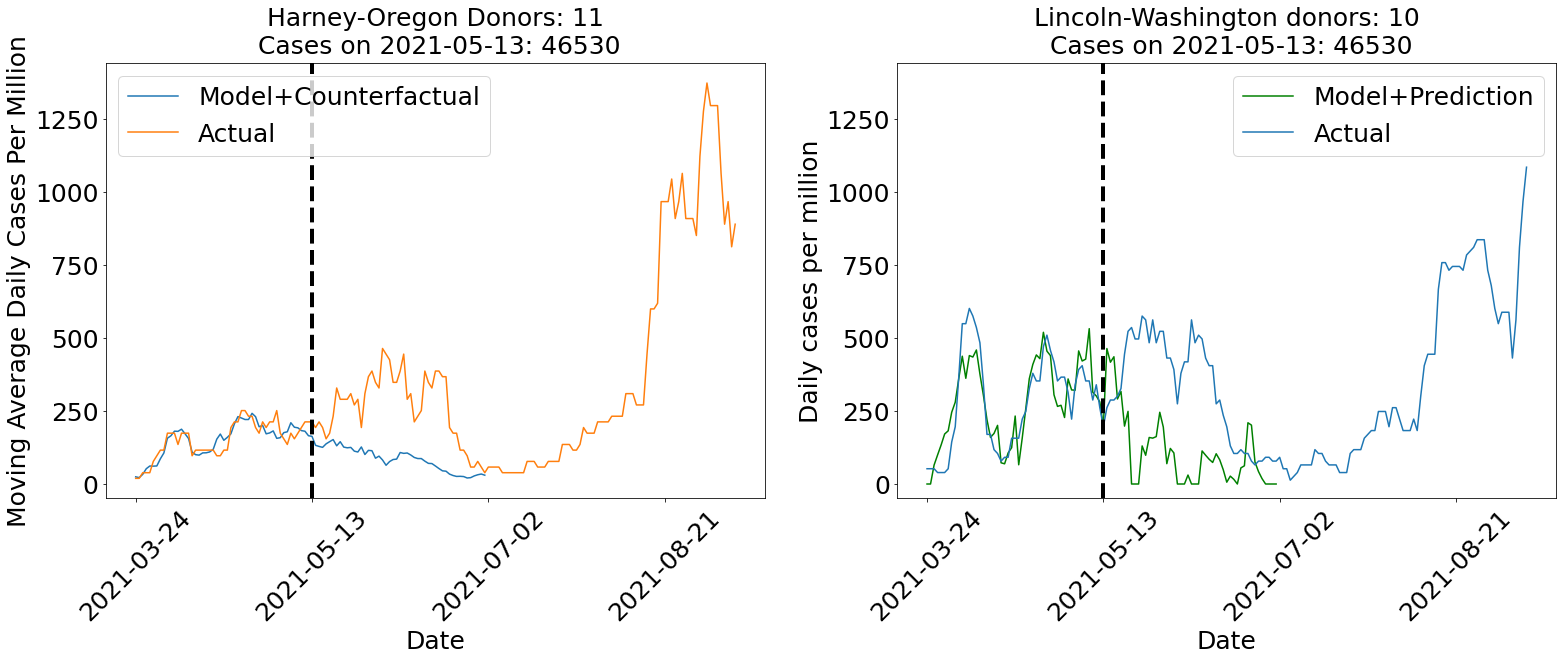

11
Hood River-Oregon 134.14226241745683


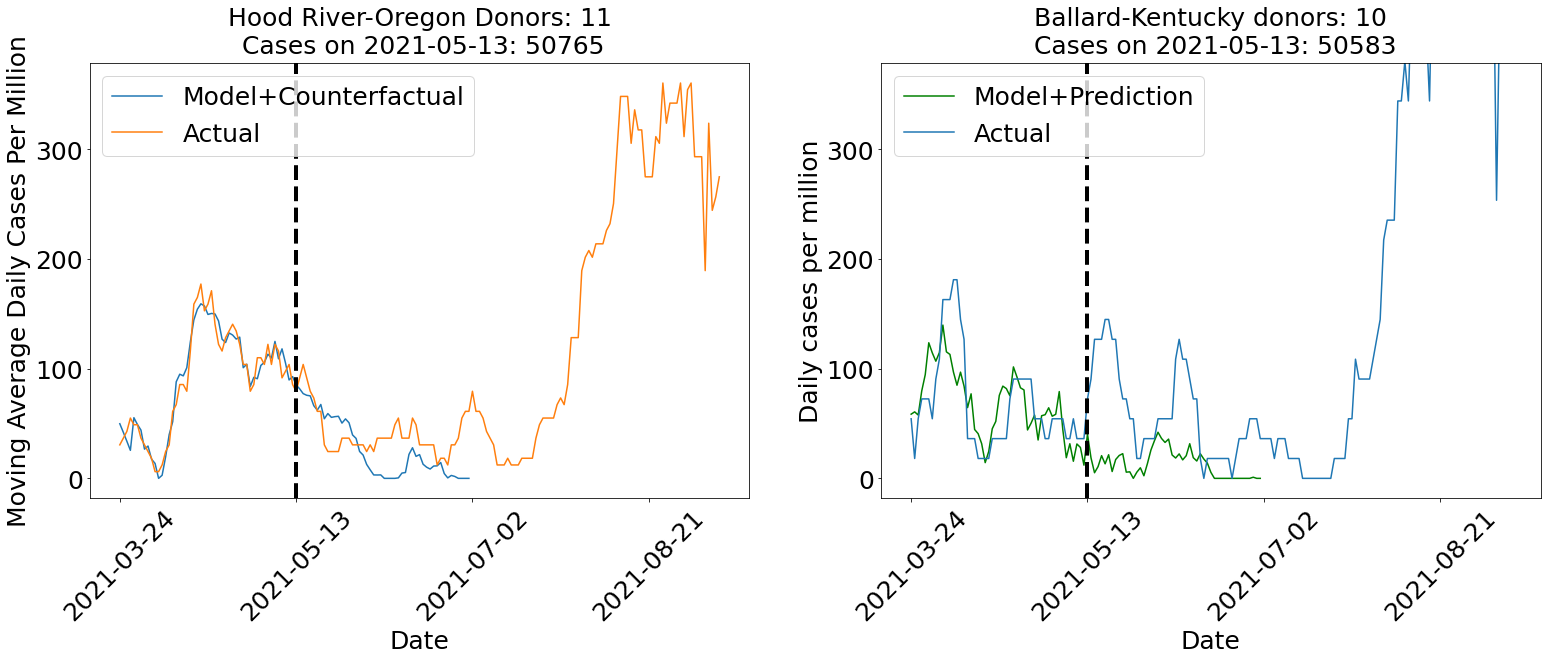

8
Jackson-Oregon 589.0402583486753
74
Jefferson-Oregon 283.21526119221147


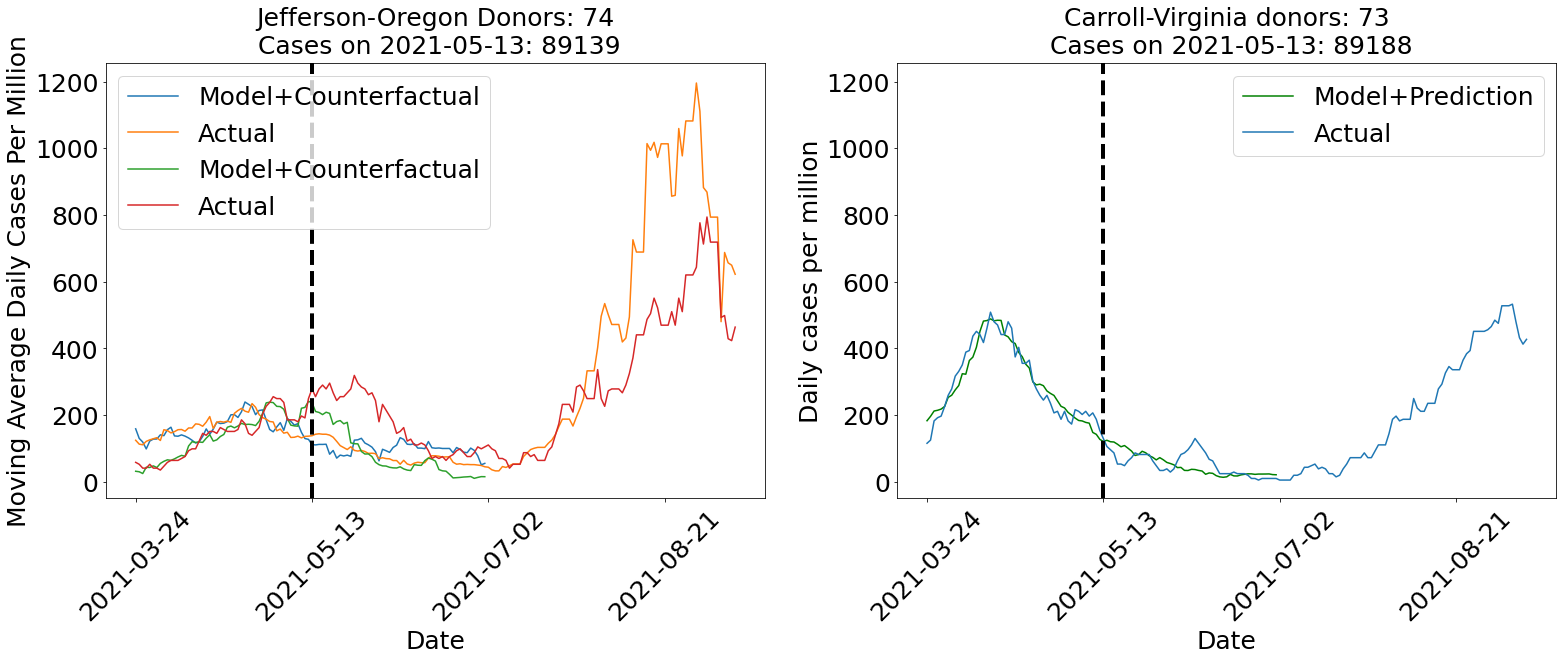

7
Josephine-Oregon 557.9536333594566


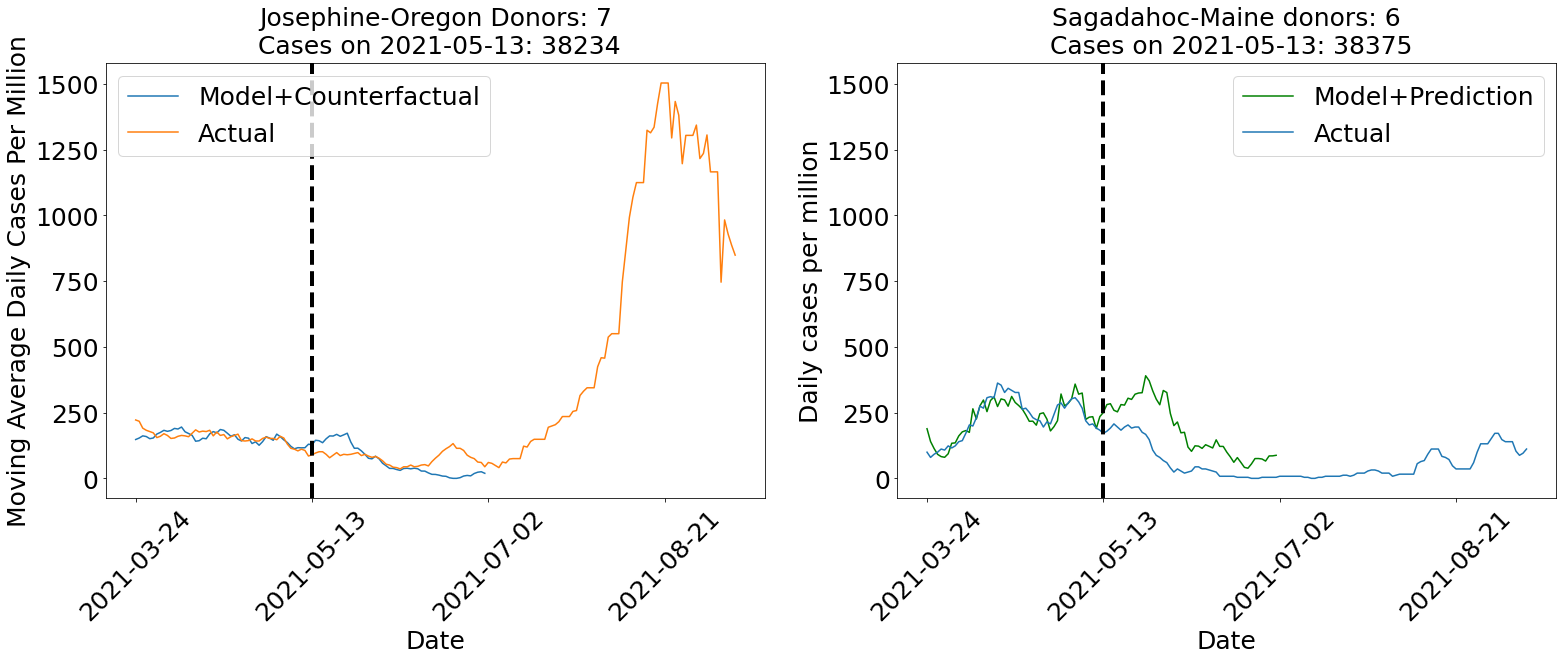

23
Klamath-Oregon 1715.6505079300937


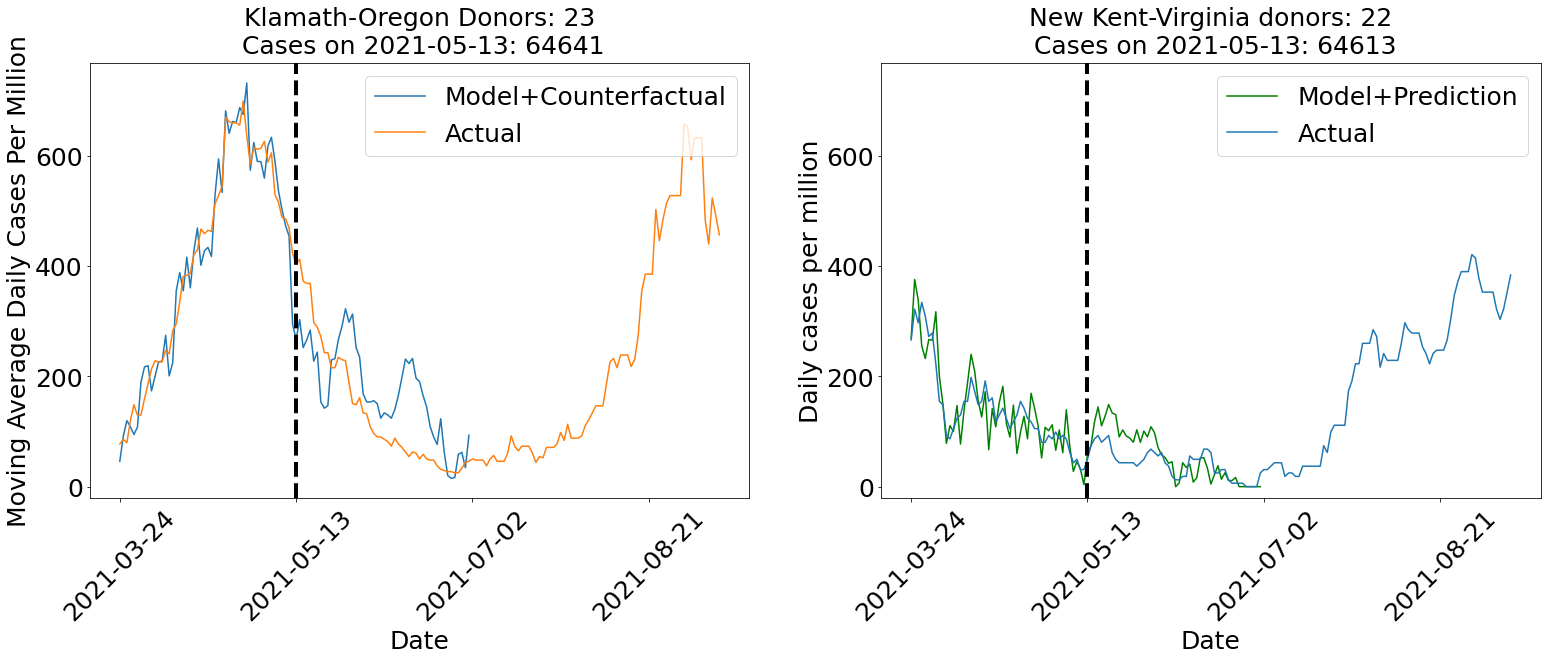

17
Lake-Oregon 688.2078713675891


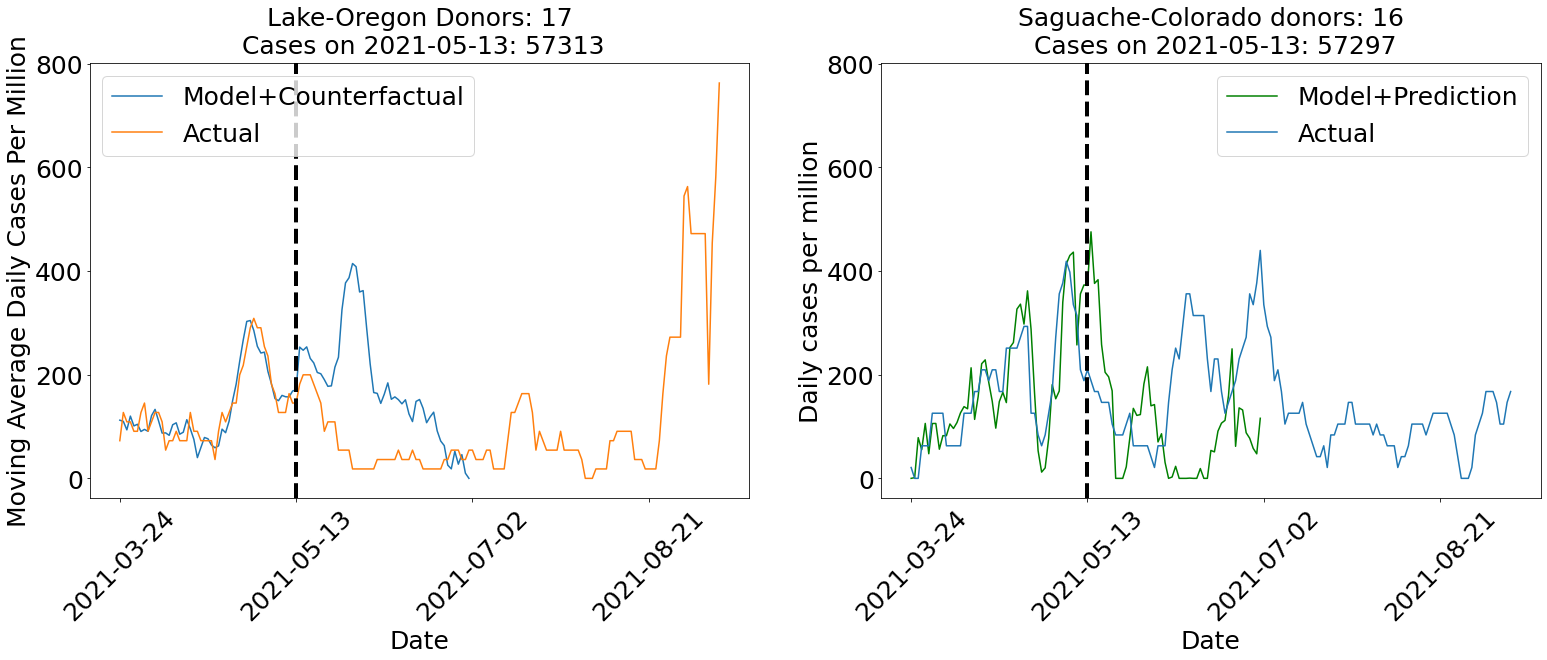

3
3
4
4
6
Linn-Oregon 3217.6332209835637


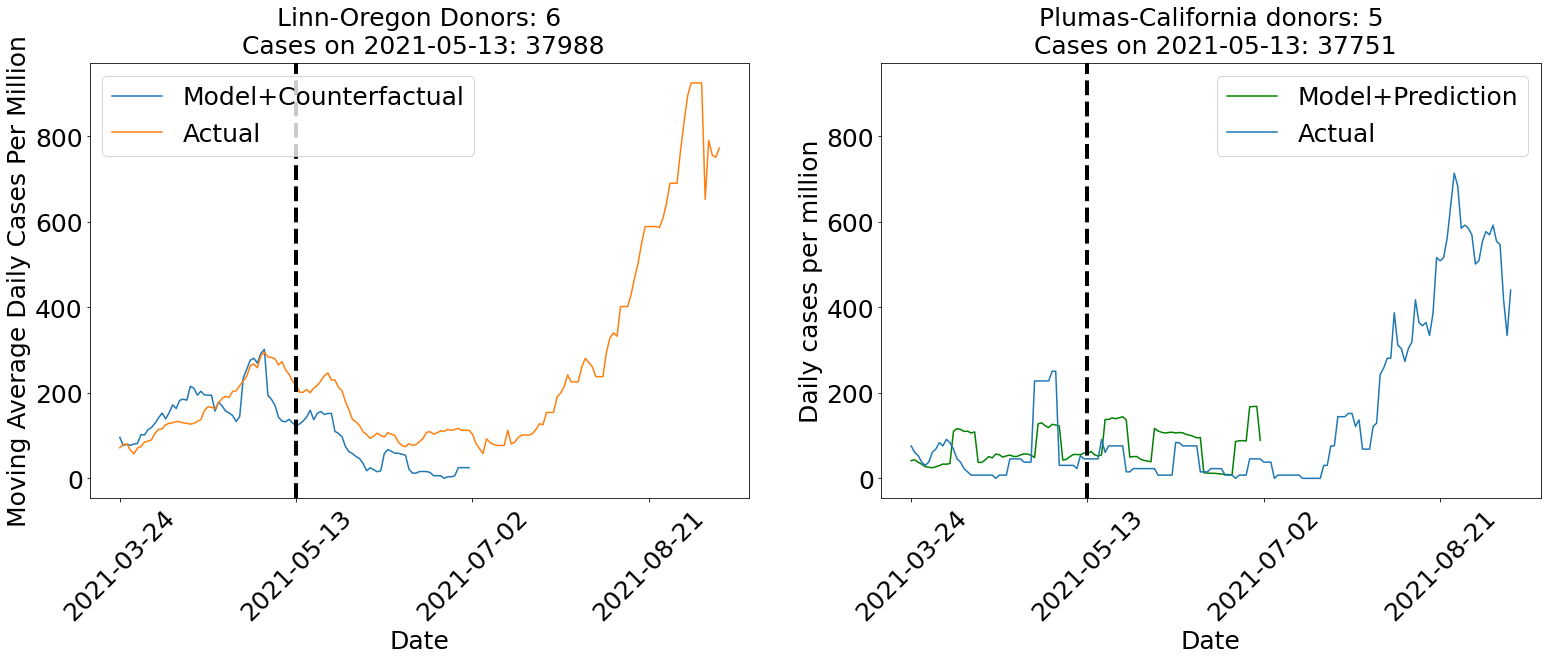

63
Malheur-Oregon 97.34625790472815


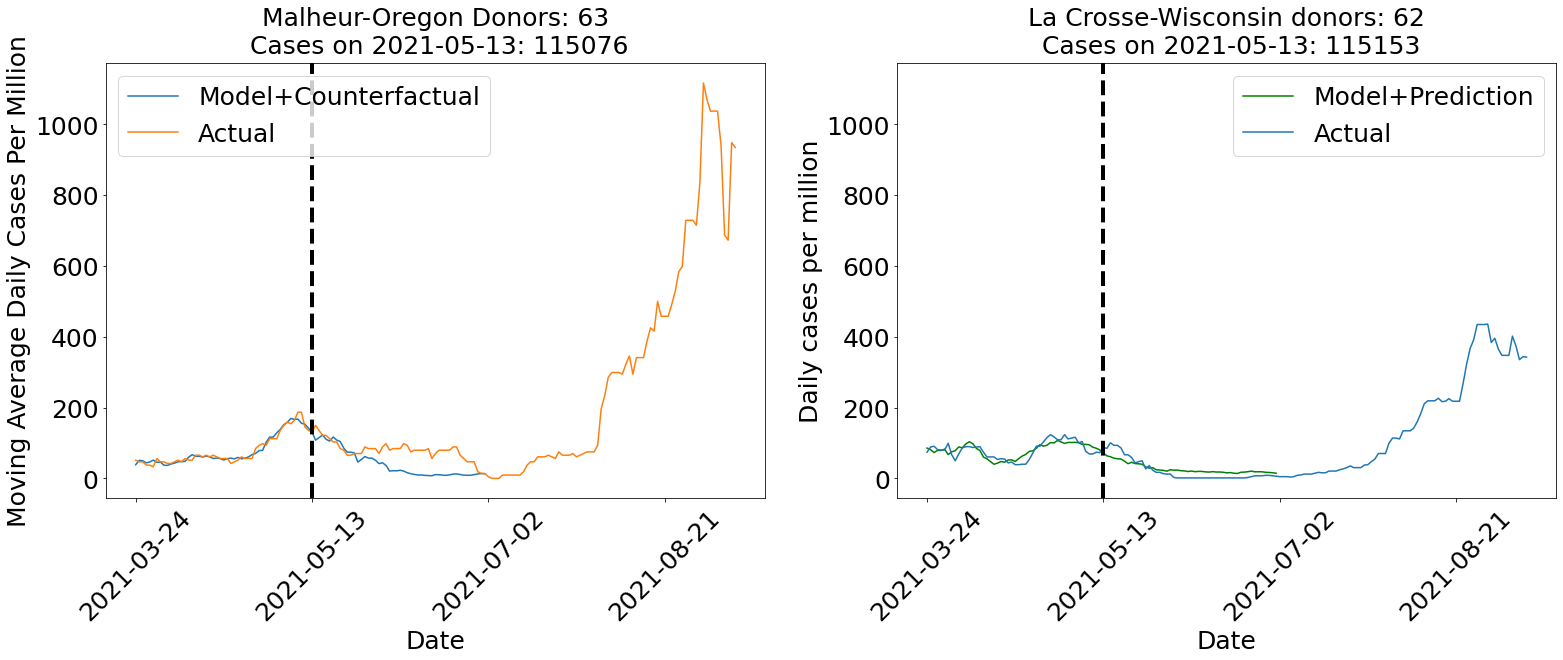

27
Marion-Oregon 395.2552504625781


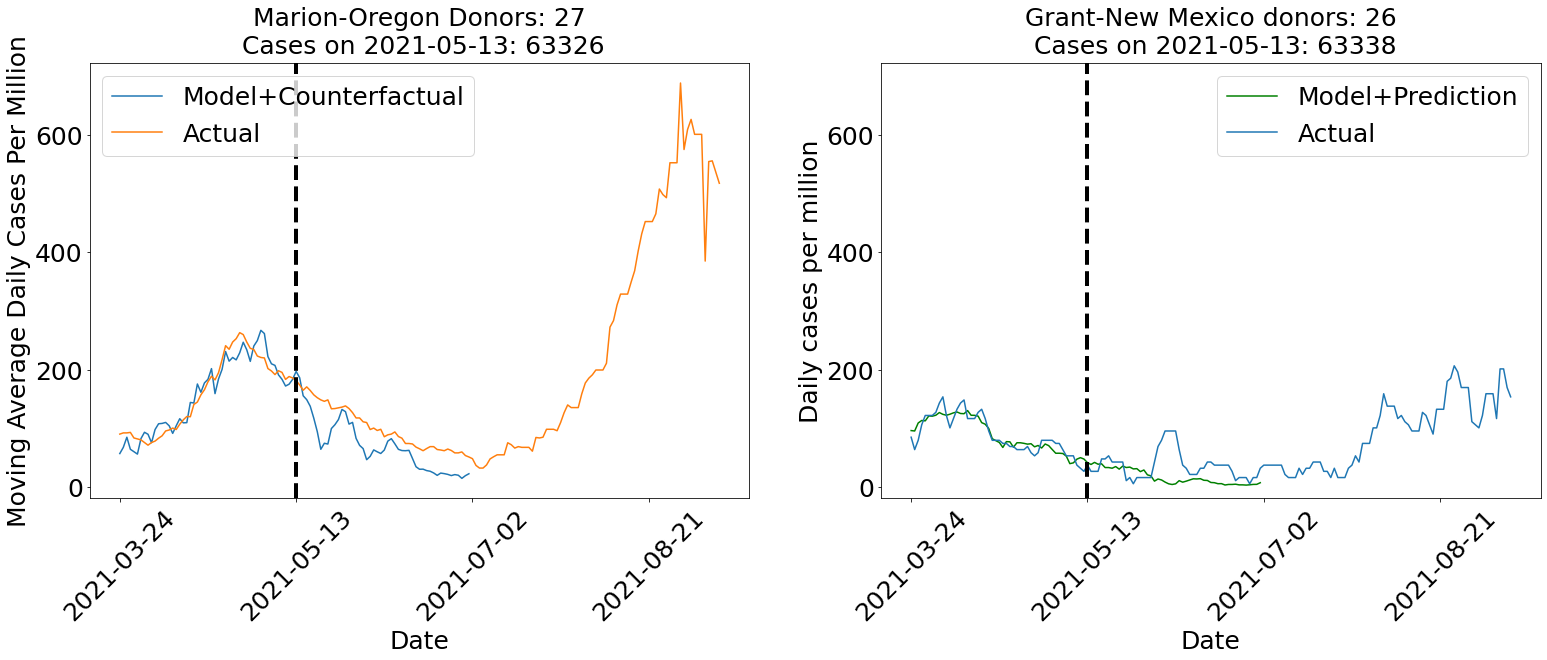

88
Morrow-Oregon 583.986420000991


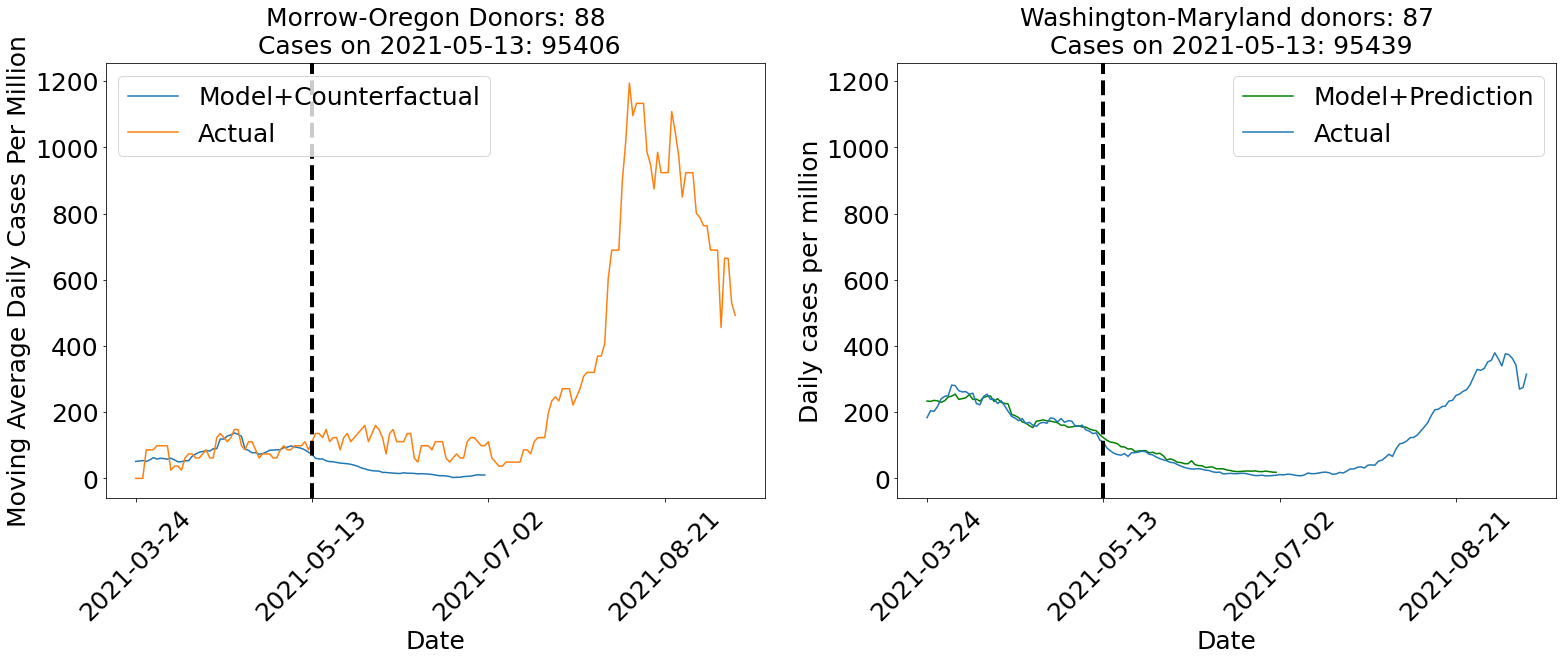

10
Multnomah-Oregon 379.06588269289904


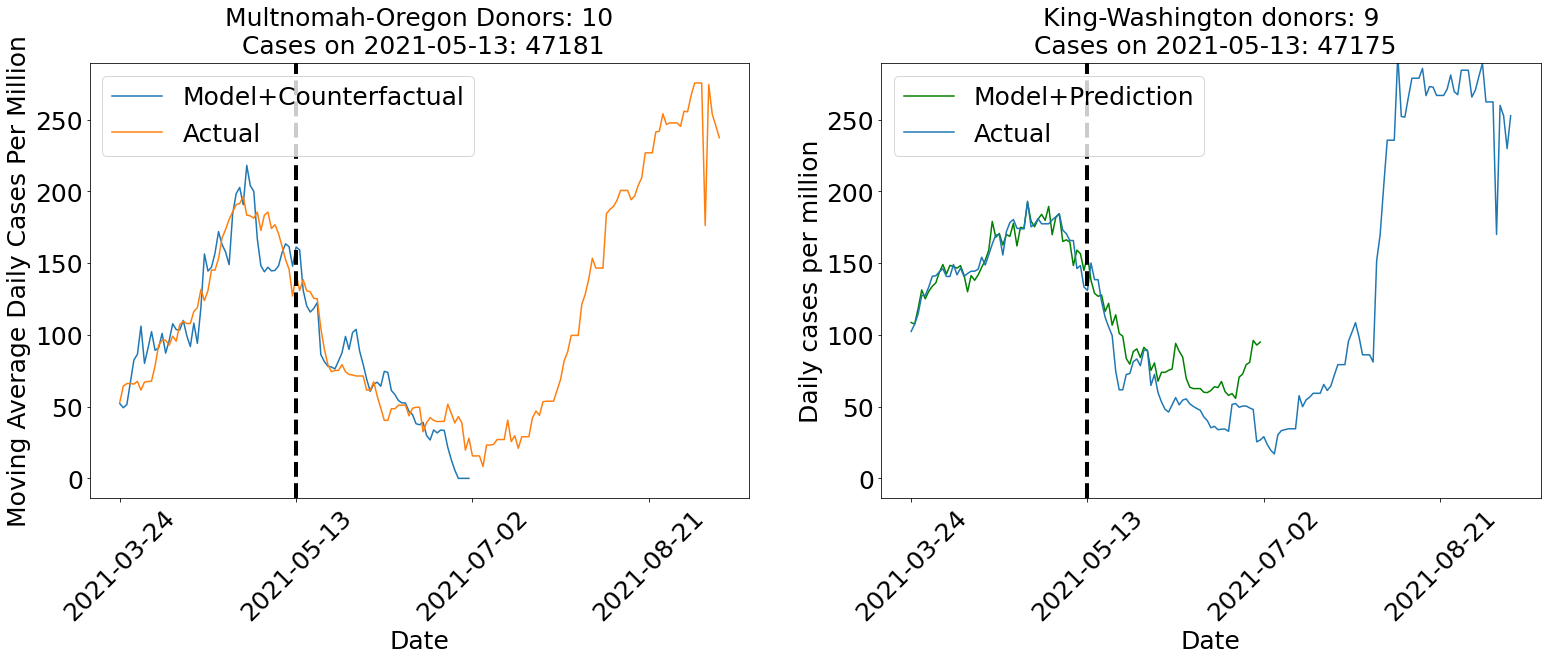

3
3
2
2
0
0
85
13
Union-Oregon 185.25776109711492


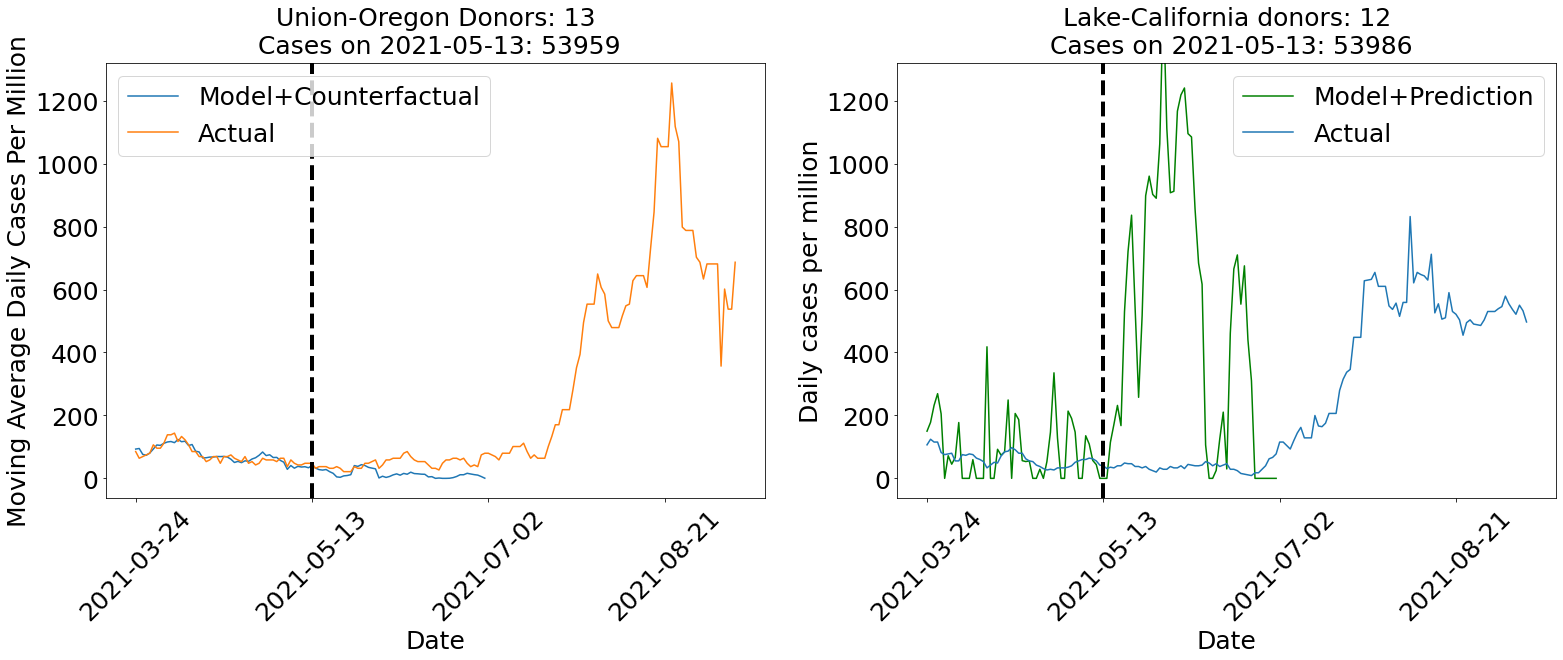

1
1
10
Wasco-Oregon 1071.5172710757192


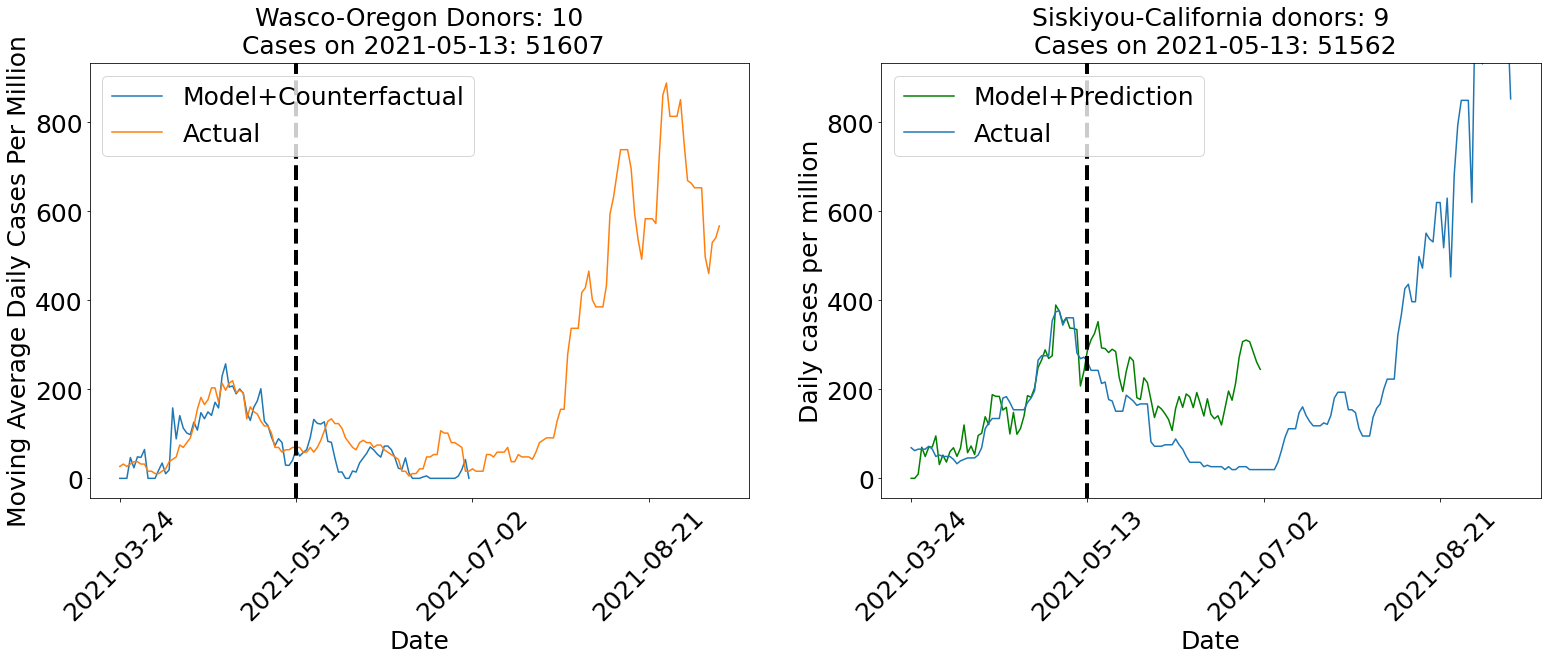

2
2
0
0
5
Yamhill-Oregon 780.011167875716


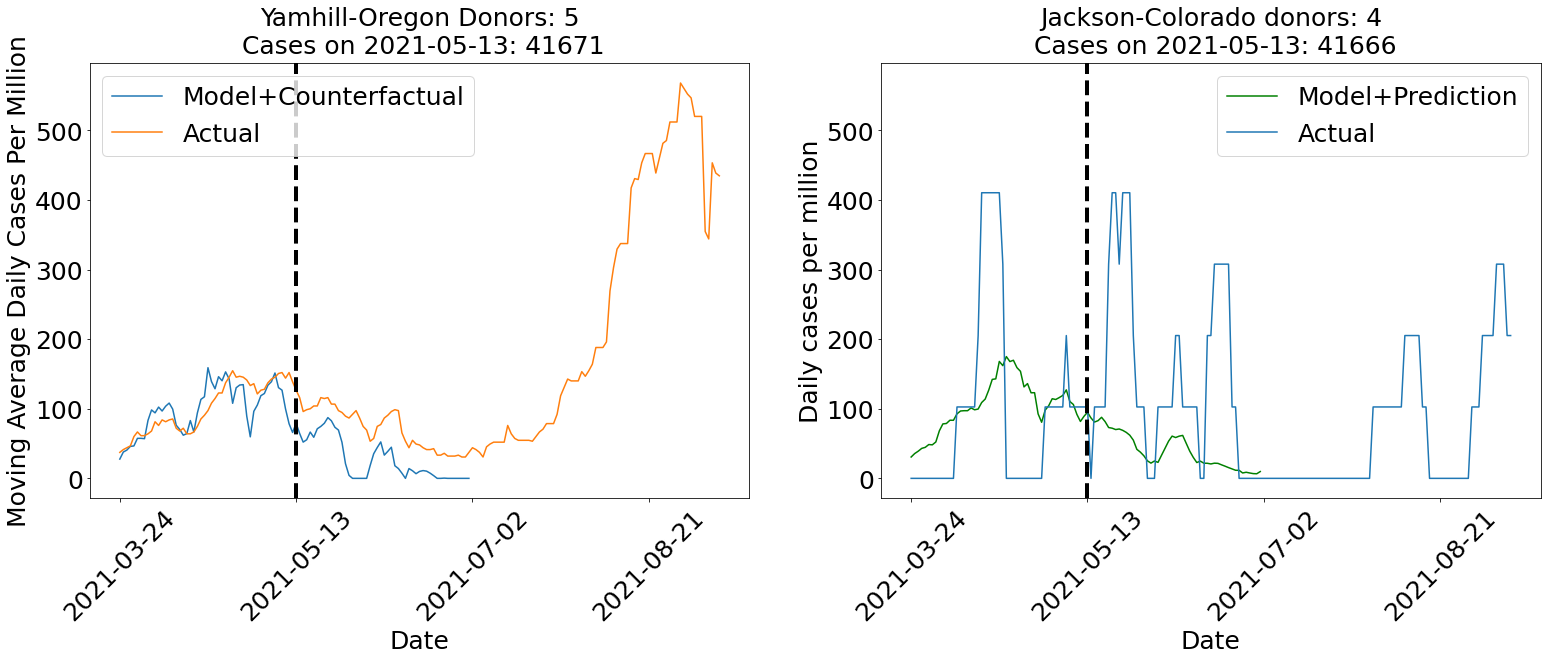

In [45]:

#df = df[df.columns[(df>100).any()]].copy()

data_df = all_cases_data_pop_daily.loc[start_date:].iloc[:200]
df_pop = all_cases_data_pop.loc[start_date:].iloc[:200]
prediction_range = 50

plt.rcParams.update({'font.size': 30})
tick_spacing = 50
FONTSIZE = 25

temp = mask_df[target_state].loc[start_date:].iloc[:date_range]
intervention_date = np.arange(1, len(temp))[np.diff(temp) < 0][0]
if intervention_date < 30:
    print("Not Enough training date")
    pass

low_thresh = np.minimum(intervention_date, 50)
cur_data_df = data_df.iloc[np.maximum(0, intervention_date - 50):]
cur_pop_df = df_pop.iloc[np.maximum(0, intervention_date - 50):]


# targets = ['Jefferson-Louisiana', 'Bartholomew-Indiana' , \
#            'Broward-Florida', 'Riverside-California', 'Crisp-Georgia', \
#            'Bullock-Alabama']#counties_recommended #counties_recommended

#targets = list(df_pop.loc[low_thresh_date, targets].sort_values().keys())

singVals=6

num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

mask_mandate_model = []
target_model = []

i=1
print("Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties")

sum_actual_target = np.zeros(prediction_range)
sum_pred_target = np.zeros(prediction_range)

sum_actual_donors = np.zeros(prediction_range)
sum_pred_donors = np.zeros(prediction_range)

for state in targets:
    #otherStates = donors.copy()
    otherStates = cur_pop_df.columns[(cur_pop_df.iloc[low_thresh] < 
                                  cur_pop_df[state].iloc[low_thresh]+0.02*cur_pop_df[state].iloc[low_thresh])
                                &(cur_pop_df.iloc[low_thresh] > cur_pop_df[state].iloc[low_thresh]-0.02*cur_pop_df[state].iloc[low_thresh])]
    
    otherStates = list(otherStates[otherStates.isin(donors)])
    print(len(otherStates))
    

    if state in otherStates:
        otherStates.remove(state)
    if (len(otherStates)<5):
        print(len(otherStates))
        continue
        
    try:

        rscModel = syn_model(state, singVals, [cur_data_df], low_thresh + prediction_range, low_thresh, otherStates=otherStates)
        rscModel.fit_model(filter_donor = True, filter_method = 'hbo', singVals_estimate = True, singval_mathod ='auto')
        target_model.append(rscModel)
    except:
        continue
        
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
    
    sum_actual_target += rscModel.actual[rscModel.low_thresh:rscModel.thresh].values 
    sum_pred_target += predictions

    #print(state, fit_error, prediction_error)
    if(len(otherStates)<5):
        print(otherStates)
        continue
    if(rscModel.train_err > 60):
        print(state, rscModel.train_err)
    else:
        print(state)

    #ax = plt.subplot(num_rows_to_plot,2,2*i-1)
    ax = plt.subplot(1,2,1)
    #fig, ax = plt.subplots(1,1)
        
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" Donors: "+str(len(otherStates))
                 + "\n Cases on "+ cur_pop_df.index[low_thresh]+ ": " + str(int(cur_pop_df[state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(cur_data_df[state], label='Actual'), 
    plt.ylabel('Moving Average Daily Cases Per Million',fontsize=FONTSIZE),
    plt.axvline(x=cur_data_df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize=FONTSIZE)
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    y_min, y_max = ax.get_ylim()
    
    new_state = otherStates[np.argmin(np.abs(cur_pop_df[otherStates].iloc[low_thresh]-cur_pop_df[state].iloc[low_thresh]))]
    #otherStates = df.columns[(df.iloc[low_thresh] < df[new_state].iloc[low_thresh]+
    #                          .5*df[new_state].iloc[low_thresh])&(df.iloc[low_thresh] > df[new_state].iloc[low_thresh]-0.5*df[new_state].iloc[low_thresh])]
    #otherStates = list(otherStates[otherStates.isin(donors)])
    #print(state, "\n", len(otherStates))
    
    if new_state in otherStates:
        otherStates.remove(new_state)
    
    try:

    
        rscModel2 = syn_model(new_state, singVals, [cur_data_df], low_thresh + prediction_range, low_thresh, otherStates=otherStates)

        rscModel2.fit_model(filter_donor = True, filter_method = 'hbo', singVals_estimate = True, singval_mathod ='auto')



        mask_mandate_model.append(rscModel2)
    except:
        continue
    
    predictions = rscModel2.predictions
    model_fit = rscModel2.model_fit
    
    sum_actual_donors += rscModel2.actual[rscModel2.low_thresh:rscModel2.thresh].values 
    sum_pred_donors += predictions
    
    #ax = plt.subplot(num_rows_to_plot,2,2*i)
    ax = plt.subplot(1,2,2)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(new_state+" donors: "+str(len(otherStates))
                 + "\n Cases on "+ cur_pop_df.index[low_thresh]+ ": " + str(int(cur_pop_df[new_state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)

    plt.plot(np.concatenate((model_fit, predictions)), color='green', label='Model+Prediction'),
    plt.plot(cur_data_df[new_state], label='Actual'), plt.legend(fontsize = FONTSIZE), 
    plt.ylabel('Daily cases per million',fontsize = FONTSIZE),
    plt.ylim([y_min, y_max])
    plt.axvline(x=cur_data_df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize = FONTSIZE)
    #plt.savefig("../figures/"+state+".png")
    
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    
    i=i+1
    #plt.savefig('../Figures/COVID/'+state+'_'+new_state+'.pdf', bbox_inches='tight')

    plt.show()
    

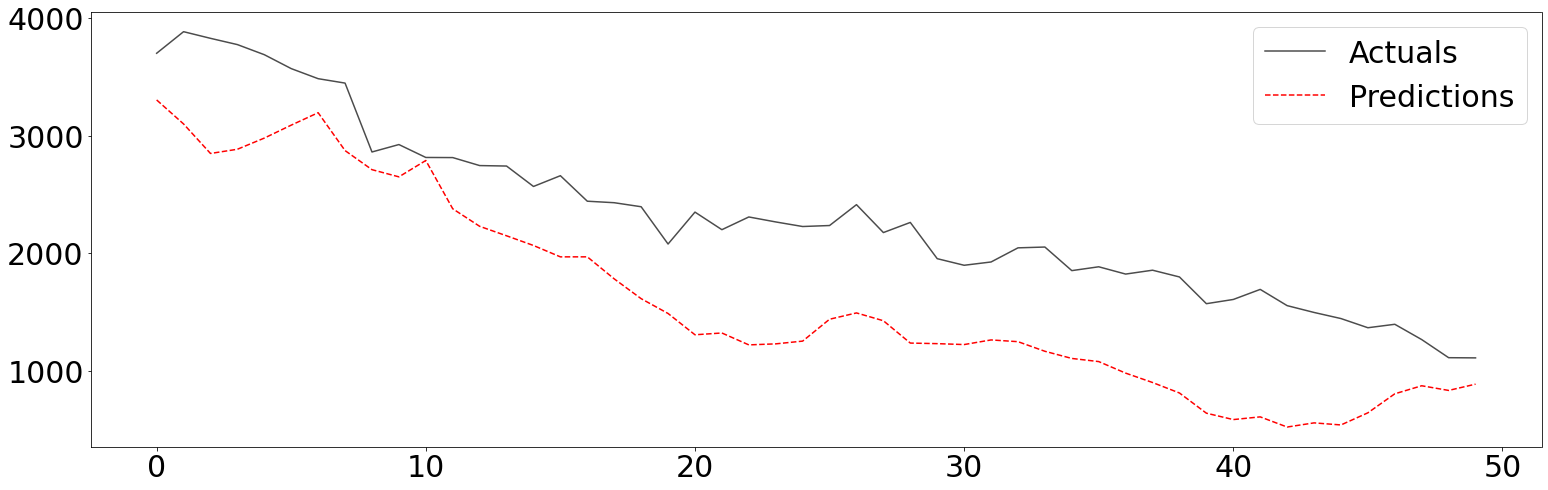

In [46]:
## Aggregate graph for targets
plt.plot(sum_actual_target, label='Actuals', color='k', linestyle='-', alpha = 0.7)
plt.plot(sum_pred_target, label='Predictions', color='r', linestyle='--')
plt.legend()
plt.show()

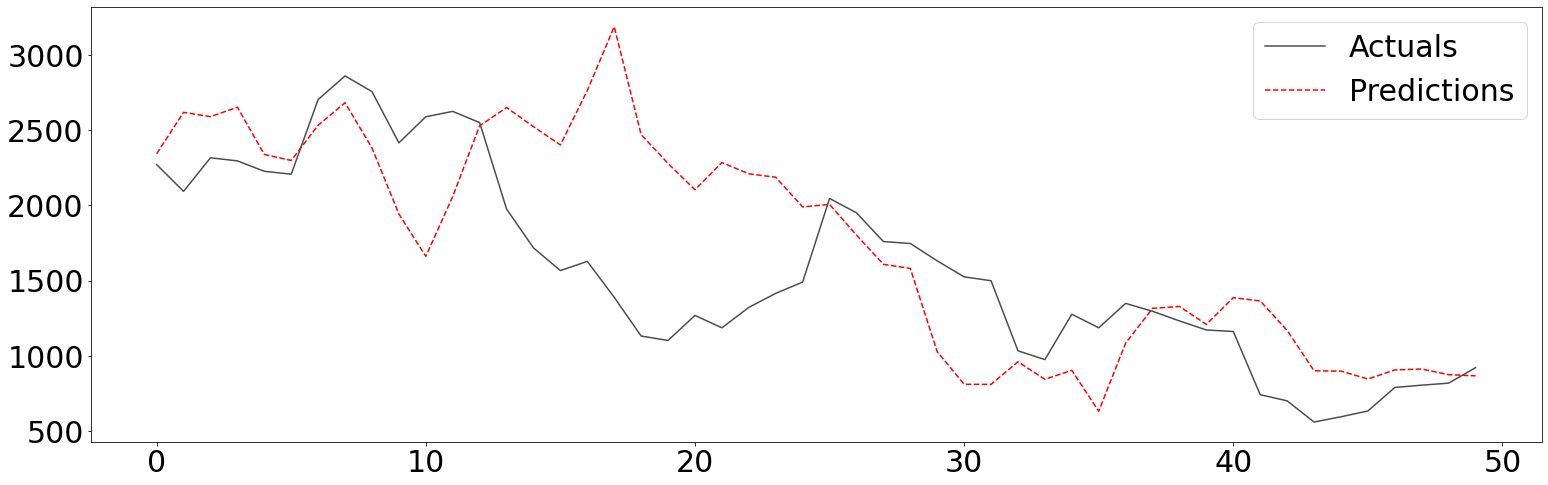

In [47]:
## aggregate graph for donors
plt.plot(sum_actual_donors, label='Actuals', color='k', linestyle='-', alpha = 0.7)
plt.plot(sum_pred_donors, label='Predictions', color='r', linestyle='--')
plt.legend()
plt.show()

### For population graph

In [108]:
pop_scaled = create_population_adjusted_data(uscounties_cases.loc[start_date:] - uscounties_cases.loc[start_date], 
                                uscounties_population)
data_df = all_cases_data_pop_daily.loc[start_date:].iloc[:200]

#Filter counties with 0 cases
accepted_counties = data_df.columns[np.sum(data_df == 0, axis = 0) < 10]
data_df = data_df[accepted_counties]

In [109]:
state_intervention_date = {}
prediction_range = 50

for state in policy_change:
    temp = mask_df[state].loc[start_date:].iloc[:date_range]
    intervention_date = np.arange(1, len(temp))[np.diff(temp) < 0][0]

    low_thresh = np.minimum(intervention_date, 80)
    cur_data_df = data_df.iloc[np.maximum(0, intervention_date - 80):]
    cur_pop_df = pop_scaled.iloc[np.maximum(0, intervention_date - 80):]
    
    if intervention_date > 60:
        print(state, low_thresh)
        state_intervention_date[state] = [low_thresh, cur_data_df, cur_pop_df]

Louisiana 64
Rhode Island 80
New Jersey 80
Maine 63
Massachusetts 80
Oregon 79
Nevada 79
Ohio 80
Vermont 80
Wisconsin 80
Colorado 80
Washington 80
Kentucky 80
New Mexico 80
Maryland 80
Pennsylvania 80
New York 80
Virginia 80
North Carolina 66
Minnesota 73
West Virginia 80
Connecticut 80


In [110]:


donors = []
for counties in data_df.columns:
    names = counties.split('-')
    if names[-1] in mask_mandate and names[0] != 'Unknown':
        donors.append(counties)
        
all_targets = []
for counties in data_df.columns:
    names = counties.split('-')
    
    #if names[-1] in non_mask_mandate and names[0] != 'Unknown':
    
    if names[-1] in policy_change and names[-1] in state_intervention_date and names[0] != 'Unknown':
        all_targets.append(counties)
        
        
#targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']#, 'Fulton-Georgia','Gwinnett-Georgia', 'Tarrant-Texas', 'Bexar-Texas','Collin-Texas','Mohave-Arizona','Yuma-Arizona','Maricopa-Arizona', 'Ascension-Louisiana',  'East Carroll-Louisiana']#counties_recommended# ['Ascension-Louisiana', 'Jefferson-Louisiana', 'Bartholomew-Indiana', 'Riverside-California', 'Broward-Florida' ]# #counties_recommended #masks_mandated


In [111]:
def generate_donors(target, pop_df, low_thresh, all_donors, donor_pool_length = 50):
#     otherStates = pop_df.columns[(pop_df.iloc[low_thresh] < 
#                                   pop_df[target].iloc[low_thresh]+alpha*pop_df[target].iloc[low_thresh])
#                                 &(pop_df.iloc[low_thresh] > pop_df[target].iloc[low_thresh]-alpha*pop_df[target].iloc[low_thresh])]
    
#     while len(otherStates) > 50:
        
#         alpha = alpha * 0.8
        
#         otherStates = pop_df.columns[(pop_df.iloc[low_thresh] < 
#                                   pop_df[target].iloc[low_thresh]+alpha*pop_df[target].iloc[low_thresh])
#                                 &(pop_df.iloc[low_thresh] > pop_df[target].iloc[low_thresh]-alpha*pop_df[target].iloc[low_thresh])]

    shared_donors = pop_df.columns[pop_df.columns.isin(all_donors)]
    
    idx = np.argsort(np.abs(pop_df[shared_donors].iloc[low_thresh]-pop_df[target].iloc[low_thresh]))[:donor_pool_length]

    return list(shared_donors[idx])
        
    
    

In [95]:
#### FOR DEBUG
target = "Mendocino-California"
target_state = target.split("-")[-1]

low_thresh, cur_data_df, cur_pop_df = 80, data_df, pop_scaled
#low_thresh, cur_data_df, cur_pop_df = state_intervention_date[target_state]

otherStates = generate_donors(target, cur_pop_df, low_thresh, donors)
if target in otherStates:
    otherStates.remove(target)
otherStates = np.array(otherStates)

otherStates = list(otherStates[~np.all(cur_data_df[otherStates] == 0, axis = 0)])

rscModel = syn_model(target, singVals, [cur_data_df], low_thresh + prediction_range, low_thresh, otherStates=otherStates)
rscModel.fit_model(filter_donor = False, filter_method = 'hbo', singVals_estimate = False, singval_mathod ='auto')


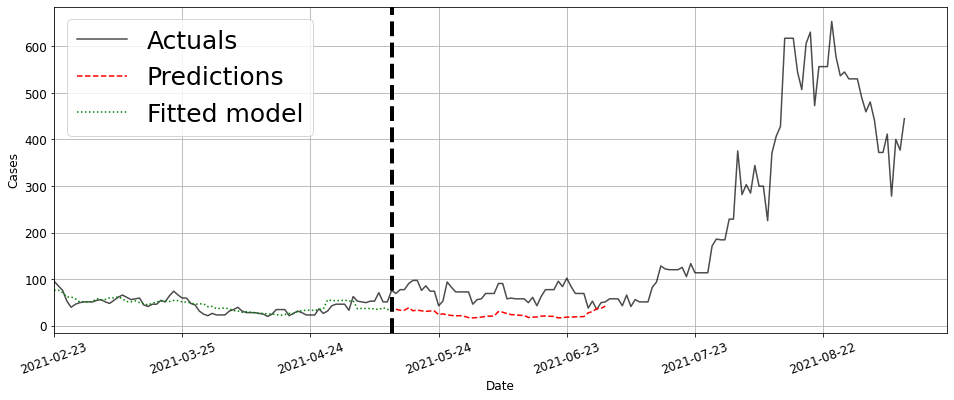

In [96]:
rscModel.plot()

In [94]:
# Debug 
predictions = rscModel.predictions
model_fit = rscModel.model_fit
pred_actual = rscModel.test[target]
train_actual = rscModel.train[target]

fit_error = rscModel.test_err

r_squ_test = find_r_square(pred_actual, predictions)
r_squ_train = find_r_square(train_actual, model_fit)
print("R^2 test: %2.2f train: %2.2f"%(r_squ_test, r_squ_train))

R^2 test: -8.07 train: 0.16


In [114]:
from sklearn.metrics import mean_squared_error

def find_r_square(y_actual, y_pred):
    ss = np.sum(np.square(y_actual - y_pred))
    tot = np.sum(np.square(y_actual - np.mean(y_actual)))
    
    return 1 - ss/tot

def find_testing_diversion(y_actual, y_pred):
    #return np.sum((y_actual - y_pred) ** 2) / len(y_actual)/np.sqrt(np.square(y_actual).sum())
    
    return np.mean(y_actual - y_pred)
#     val = np.sum(np.maximum(y_actual - y_pred, 0) **2)/len(y_actual)
    
#     return val
    
#     if val > 0:
#         return val/np.sum((y_actual - y_pred) > 0)
    
#     else:
#         return 0
    
    #return np.sum((y_actual - y_pred))/(np.sum(y_pred))

    
    #return np.sum((y_actual - y_pred)**2)/(len(y_pred))

#df = df[df.columns[(df>100).any()]].copy()

all_diversion = {}
donor_diversion = {}

for i in range(3500, 10000, 500):
    
    counties_close = find_close(pop_scaled, "2021-05-14", i, 250, \
                          county = True)
    
    cur_targets = list(set(counties_close).intersection(all_targets))
    donorpool_counties = list(set(counties_close).intersection(donors))
    print("-------------------------------------%s--------------------------------"%i)
    print("length target", len(cur_targets))
    print("length donor", len(donorpool_counties))
    
    
    cur_targets = list(np.random.choice(cur_targets, size = np.min([50, len(cur_targets)]), replace = False))
    donorpool_counties = list(np.random.choice(donorpool_counties, 
                                               size = np.min([50, len(donorpool_counties)]), replace = False))
                       
    
    cur_diversion = np.empty(len(cur_targets))
    d_diversion = np.empty(len(donorpool_counties))
    
    target_counts = 0
    donor_counts = 0
    
    print("-------------------------------------FOR TARGET--------------------------------")
    
    for target in cur_targets:
        
        print(target)
        
        
        
        target_state = target.split("-")[-1]

        low_thresh, cur_data_df, cur_pop_df = state_intervention_date[target_state]
        #low_thresh, cur_data_df, cur_pop_df = 80, data_df, pop_scaled
        
        #print("cases ", cur_pop_df[target].iloc[low_thresh])
        
        otherStates = np.array(generate_donors(target, cur_pop_df, low_thresh, donors))

        otherStates = list(otherStates[~np.all(cur_data_df[otherStates] == 0, axis = 0)])
#         otherStates = list(otherStates[otherStates.isin(donors)])

        
        print(target, len(otherStates))

        if target in otherStates:
            otherStates.remove(target)
        if (len(otherStates)<5):
            print(len(otherStates))
            continue
        
        rscModel = syn_model(target, singVals, [cur_data_df], low_thresh + prediction_range, low_thresh, otherStates=otherStates)
        rscModel.fit_model(filter_donor = False, filter_method = 'hbo', singVals_estimate = False, singval_mathod ='auto')
        
        predictions = rscModel.predictions
        model_fit = rscModel.model_fit
        pred_actual = rscModel.test[target]
        train_actual = rscModel.train[target]
        
        fit_error = rscModel.test_err
        
        r_squ_test = find_r_square(pred_actual, predictions)
        r_squ_train = find_r_square(train_actual, model_fit)
        print("R^2 test: %2.2f train: %2.2f"%(r_squ_test, r_squ_train))
        
#         if(fit_error > 1500):
#             print(target, 'error is: ', fit_error)
#             continue
        #/cur_pop_df.iloc[low_thresh][target]
        diversion = find_testing_diversion(pred_actual, predictions)/cur_pop_df.iloc[low_thresh][target]
        #diversion = fit_error

        
        if diversion > 1e5:
            continue
        print("diversion", diversion, " ", cur_pop_df.iloc[low_thresh][target])
        
        cur_diversion[target_counts] = diversion
        target_counts += 1
    print("-------------------------------------FOR DONOR--------------------------------")
    
    for state in donorpool_counties:
        
        low_thresh, cur_data_df, cur_pop_df = 80, data_df, pop_scaled
        
        otherStates = np.array(generate_donors(state, cur_pop_df, low_thresh, donors))

        otherStates = list(otherStates[~np.all(cur_data_df[otherStates] == 0, axis = 0)])
        
#         otherStates = generate_donors(state, cur_pop_df, low_thresh)
#         otherStates = list(otherStates[otherStates.isin(donors)])
        
        print(state, len(otherStates))
        
        if state in otherStates:
            otherStates.remove(state)
            
            
        if (len(otherStates)<5):
            continue
            
        rscModel = syn_model(state, singVals, [cur_data_df], low_thresh + prediction_range, low_thresh, otherStates=otherStates)
        rscModel.fit_model(filter_donor = False, filter_method = 'hbo', singVals_estimate = False, singval_mathod ='auto')
        
        
        predictions = rscModel.predictions
        model_fit = rscModel.model_fit
        pred_actual = rscModel.test[state]
        train_actual = rscModel.train[state]
        
        fit_error = rscModel.test_err
        
        r_squ_test = find_r_square(pred_actual, predictions)
        r_squ_train = find_r_square(train_actual, model_fit)
        print("R^2 test: %2.2f train: %2.2f"%(r_squ_test, r_squ_train))
        
        fit_error = rscModel.test_err
        
#         if(fit_error > 1500):
#             print(state, 'error is: ', fit_error)
#             continue

        #/cur_pop_df.iloc[low_thresh][state]
    
        #/cur_pop_df.iloc[low_thresh][state]
        diversion = find_testing_diversion(pred_actual, predictions)/cur_pop_df.iloc[low_thresh][state]
        #diversion = fit_error
        
        if diversion > 1e5:
            continue
        print("diversion", diversion)
        
        d_diversion[donor_counts] = diversion
        donor_counts += 1 
    
    all_diversion[i] = ([cur_diversion,target_counts] )
    donor_diversion[i] = ([d_diversion, donor_counts])
        
        

        

-------------------------------------3500--------------------------------
length target 6
length donor 5
-------------------------------------FOR TARGET--------------------------------
Clark-Wisconsin
Clark-Wisconsin 50
R^2 test: 0.15 train: 0.86
diversion -0.0027247468781539073   3652.153908092253
Franklin-Louisiana
Franklin-Louisiana 50
R^2 test: -2.48 train: 0.71
diversion 0.00979622621692919   2897.8266300274795
Nye-Nevada
Nye-Nevada 50
R^2 test: 0.00 train: 0.49
diversion 0.0010562808299224315   3589.6223373385205
Claiborne-Louisiana
Claiborne-Louisiana 50
R^2 test: -0.24 train: 0.11
diversion 0.0028251484951130447   2871.7294192724953
Elliott-Kentucky
Elliott-Kentucky 50
R^2 test: -0.48 train: 0.16
diversion 0.010017696189863558   3325.7948649727286
West Feliciana-Louisiana
West Feliciana-Louisiana 50
R^2 test: -0.19 train: 0.02
diversion 0.01689329763476573   3661.356628982528
-------------------------------------FOR DONOR--------------------------------
Lassen-California 50
R^2

R^2 test: -3.18 train: 0.35
diversion 0.008802264887276777   5678.168597929139
Van Wert-Ohio
Van Wert-Ohio 50
R^2 test: -0.35 train: 0.48
diversion -0.0030102054022398132   5729.4429708222815
Portage-Wisconsin
Portage-Wisconsin 50
R^2 test: 0.16 train: 0.57
diversion -0.0018840436962356448   5524.783812807325
Tuscarawas-Ohio
Tuscarawas-Ohio 50
R^2 test: -0.28 train: 0.61
diversion 0.0006318501229845001   5718.199310772175
Richland-Louisiana
Richland-Louisiana 50
R^2 test: -1.05 train: 0.57
diversion 0.010429230633097935   4373.322731338833
Concordia-Louisiana
Concordia-Louisiana 50
R^2 test: -2.29 train: 0.51
diversion 0.00463626671096715   4569.292278934524
Staunton city-Virginia
Staunton city-Virginia 50
R^2 test: -26.33 train: 0.64
diversion -0.009833604469003858   5535.055350553505
Hood River-Oregon
Hood River-Oregon 50
R^2 test: -0.43 train: 0.76
diversion -0.002411975322037794   5431.528526216748
-------------------------------------FOR DONOR--------------------------------
Dougl

Crawford-Kansas 50
R^2 test: -0.32 train: 0.69
diversion 0.0048516678685276825
Sutter-California 50
R^2 test: -2.99 train: 0.63
diversion 0.0031419483954754713
El Dorado-California 50
R^2 test: -3.74 train: 0.69
diversion -0.004157414163902427
Napa-California 50
R^2 test: -4.69 train: 0.62
diversion -0.002583908159136363
Leavenworth-Kansas 50
R^2 test: -1.40 train: 0.86
diversion -0.0026882714470469284
San Luis Obispo-California 50
R^2 test: -16.48 train: 0.75
diversion -0.004046893371503661
-------------------------------------7000--------------------------------
length target 21
length donor 13
-------------------------------------FOR TARGET--------------------------------
Hertford-North Carolina
Hertford-North Carolina 50
R^2 test: -0.94 train: 0.41
diversion -0.005994465149187669   6124.086666385099
Polk-North Carolina
Polk-North Carolina 50
R^2 test: 0.42 train: 0.45
diversion -0.0016336319290985526   5935.147654892878
Bienville-Louisiana
Bienville-Louisiana 50
R^2 test: -0.79 tra

Cherokee-Kansas 50
R^2 test: -1.17 train: 0.44
diversion 0.013560744976036643
-------------------------------------8000--------------------------------
length target 31
length donor 7
-------------------------------------FOR TARGET--------------------------------
Somerset-Maryland
Somerset-Maryland 50
R^2 test: 0.07 train: 0.21
diversion 0.00017535765510024945   8080.886945658963
Nelson-Kentucky
Nelson-Kentucky 50
R^2 test: -0.55 train: 0.64
diversion -0.0014135185170928576   7916.42333398222
Rapides-Louisiana
Rapides-Louisiana 50
R^2 test: -1.80 train: 0.06
diversion 0.009946472546984882   5592.064667407133
Lyon-Nevada
Lyon-Nevada 50
R^2 test: -1.68 train: 0.09
diversion -0.00076755622110826   8207.268301165015
Tompkins-New York
Tompkins-New York 50
R^2 test: -1.13 train: 0.48
diversion -0.0017837579612012613   8475.239772949697
Lea-New Mexico
Lea-New Mexico 50
R^2 test: -0.40 train: 0.57
diversion 0.0021989298631570333   8090.614886731391
Clermont-Ohio
Clermont-Ohio 50
R^2 test: -0.2

Moultrie-Illinois 50
R^2 test: -0.71 train: 0.28
diversion -0.002835036409827075
Franklin-Illinois 50
R^2 test: 0.42 train: -0.22
diversion 0.0005552269970343823
Wyandotte-Kansas 50
R^2 test: -1.43 train: 0.89
diversion 0.0007093392745276128
Shelby-Illinois 50
R^2 test: -0.38 train: 0.26
diversion -0.0024087964635334785
Johnson-Illinois 50
R^2 test: 0.34 train: 0.24
diversion 0.0025803463470039302
Macoupin-Illinois 50
R^2 test: 0.46 train: 0.29
diversion -0.0004192483653082556
Nevada-California 50
R^2 test: -13.76 train: 0.01
diversion -0.002096556089978204
-------------------------------------9000--------------------------------
length target 43
length donor 6
-------------------------------------FOR TARGET--------------------------------
Waldo-Maine
Waldo-Maine 50
R^2 test: 0.10 train: -0.07
diversion 0.00625508617620494   6269.671408787612
Addison-Vermont
Addison-Vermont 50
R^2 test: -2.23 train: 0.56
diversion -0.003371019573704607   8918.617614269788
Oconto-Wisconsin
Oconto-Wiscon

diversion 0.0004493770722818713   9460.77331538404
Wayne-Ohio
Wayne-Ohio 50
R^2 test: 0.58 train: 0.46
diversion 0.0002455702236341855   9584.30559156512
Warren-Ohio
Warren-Ohio 50
R^2 test: -1.84 train: 0.84
diversion -0.002682356807257434   9471.360005456048
Hart-Kentucky
Hart-Kentucky 50
R^2 test: 0.52 train: 0.62
diversion -0.00023449574460996162   9929.078014184397
Caldwell-Kentucky
Caldwell-Kentucky 50
R^2 test: -2.34 train: 0.65
diversion 0.002713678280790104   9570.879422609241
Kenosha-Wisconsin
Kenosha-Wisconsin 50
R^2 test: 0.73 train: 0.54
diversion -0.0008289088698319433   9388.951468792942
Otero-Colorado
Otero-Colorado 50
R^2 test: -8.85 train: 0.80
diversion -0.004043870314066315   11598.643177590546
Jefferson-Wisconsin
Jefferson-Wisconsin 50
R^2 test: -2.76 train: 0.47
diversion -0.00359553136610959   9637.957272115986
Taylor-West Virginia
Taylor-West Virginia 50
R^2 test: -0.05 train: 0.57
diversion 0.001048097174644698   9284.216831386642
Fillmore-Minnesota
Fillmore-Mi

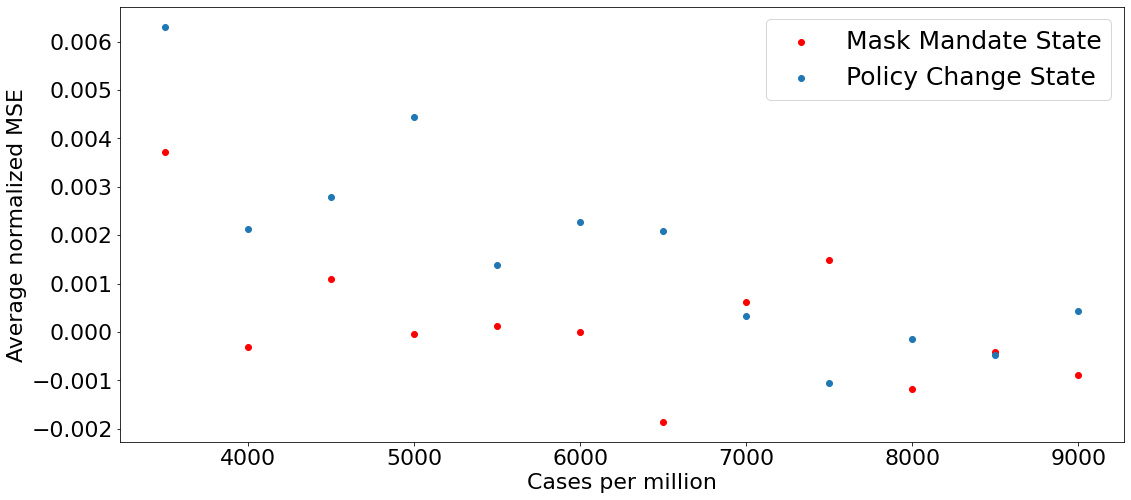

In [115]:
FONTSIZE = 22

k = -1

fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = (18, 8)

#plt.scatter(df['days to peak'], (df['peak value']), s=2*df['initial value']),
values = list(donor_diversion.values())[0:k]
plt.scatter(list(donor_diversion.keys())[0:k], [np.average(i[0]) for i in values], c = 'r', label = 'Mask Mandate State')

values = list(all_diversion.values())[0:k]
plt.scatter(list(all_diversion.keys())[0:k], [np.average(i[0]) for i in values], label = 'Policy Change State')
ax.yaxis.get_offset_text().set_fontsize(FONTSIZE)
#plt.ylim([0,1300])
#plt.title('Average diversion for counties with close infection rates using states with bars and restuarants closed as donor pool')
plt.ylabel('Average normalized MSE',fontsize = FONTSIZE)
plt.xlabel('Cases per million',fontsize = FONTSIZE)
plt.legend(fontsize = 25)
#plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=FONTSIZE)
plt.savefig('../Figures/COVID/infections_compare.pdf', bbox_inches='tight')
plt.show()




## Prediction of Delta variant by SC

### Predict after the discovery date

In [114]:

## Align the data set by discovery date of delta
df = all_cases_data_pop_daily

target = "Italy"
target_start = delta_variant_data.loc[target].values[0]
tick_spacing = 90
filter_donor_by_date = False
singVals = 6


## Use the county with delta discovery date earlier than target
if filter_donor_by_date:

    donors = list(delta_variant_data.loc[delta_variant_data['Date'] < target_start].index)
    
else:
    
    donors = list(delta_variant_data.index)
    donors.remove(target)

donor_start = delta_variant_data.loc[donors].values.flatten()

prediction_length = 120

train_length = 50

donor_start_idx = [list(df.index).index(date) - train_length for date in donor_start]
donor_end_idx =  [list(df.index).index(date) + prediction_length for date in donor_start]

target_start_idx = list(df.index).index(target_start) - train_length
target_end_idx = list(df.index).index(target_start) + prediction_length

data_df = df[target][target_start_idx:target_end_idx]
idx = data_df.index
data_df = pd.Series(data_df.values, name = target)
#print(data_df.shape)

for i in range(len(donors)):
    temp_df = df[donors[i]][donor_start_idx[i]:donor_end_idx[i]]
    data_df = pd.concat([data_df, pd.Series(temp_df.values, name = donors[i])], axis = 1)
    
data_df.index = idx



### Original

['France', 'Ireland', 'Germany', 'Denmark', 'Belgium', 'Sweden', 'Switzerland', 'Portugal', 'Norway', 'United Kingdom', 'Finland', 'Korea, South', 'Japan', 'Netherlands', 'Luxembourg', 'Austria', 'Slovenia', 'Russia', 'US', 'Spain', 'Czechia', 'Poland', 'Turkey'] 3


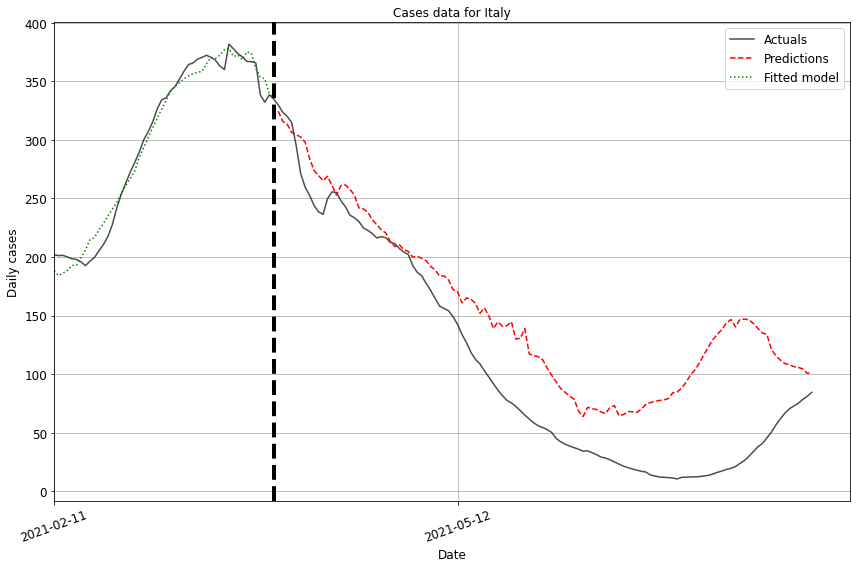

In [115]:
# sc model using the discovery date as intervention date
rscModel =syn_model(target, singVals, [data_df], train_length + prediction_length, train_length, otherStates=donors)
rscModel.fit_model(filter_donor = False, filter_method = 'percentile', singVals_estimate = True, singval_mathod ='auto')

predictions = rscModel.predictions
model_fit = rscModel.model_fit

fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()

print(rscModel.donors, rscModel.kSingularValues)

plt.show()

### HBO

outliers: ['France' 'Korea, South' 'Japan' 'Russia' 'Spain']


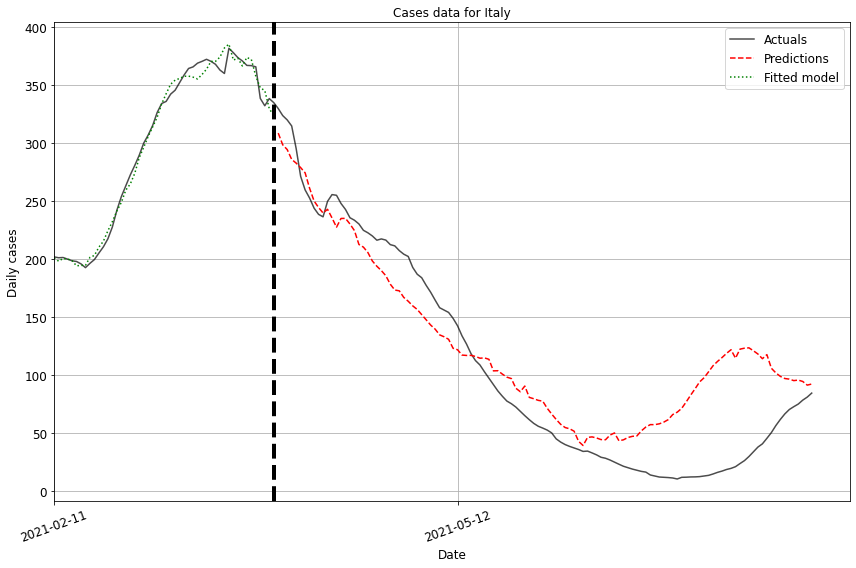

In [116]:
perm_dict = rscModel.permutation_distribution(show_graph = False, include_self = False, ri_method = 'ratio')
train_perm_dict = permutation_train_test(rscModel)
train_values = np.array(list(perm_dict.values()))

test_perm_dict = permutation_train_test(rscModel, train_err = False)
test_values = np.array(list(perm_dict.values()))

all_donors = np.array(list(perm_dict.keys()))
values = np.array(list(perm_dict.values()))

input_df =  pd.DataFrame([train_values,test_values]).transpose() # pd.DataFrame(values)
hbos = HBOS(alpha=0.1, contamination=0.15, n_bins=20, tol=0.5)
hbos.fit(input_df)
output = hbos.decision_function(input_df)
res = hbos.predict(input_df)
res = np.array(res, dtype = bool)

print('outliers:', all_donors[res])
# for item in all_donors[res]:
#     if item in outliers:
#         TP+=1
#     else:
#         FP+=1

################################################
################################################

rscModel2 =syn_model(target, singVals, [data_df], train_length + prediction_length, train_length, otherStates=list(all_donors[~res]))
try:
    rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
except Exception as e: 
    print(e)

fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel2.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()

plt.show()

### Backward



target: Italy
donors: 23 removed: ['Poland']
training error before: 98.87742713456379 training error after: 194.33105973914593


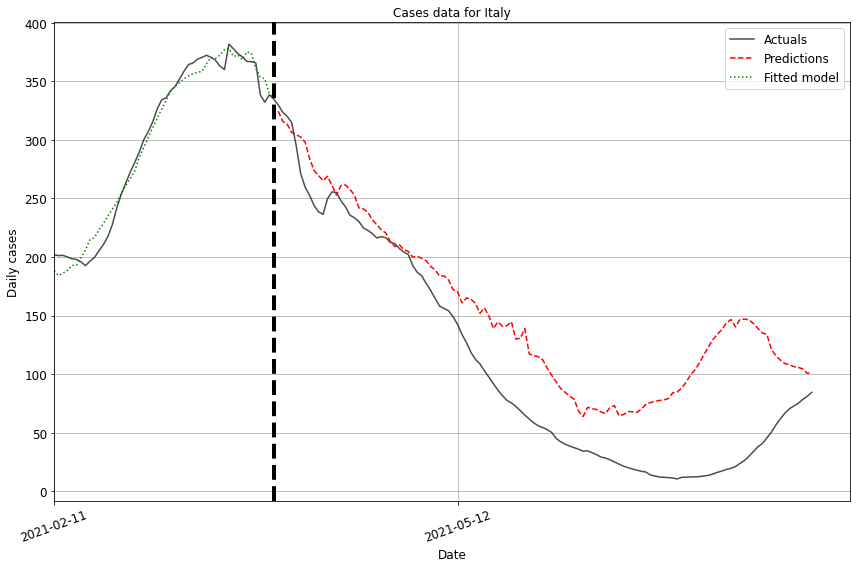

In [117]:
rscModel1 = rscModel
final_donors = rscModel1.donors
print('\n\ntarget:', target)
while len(final_donors)>3:
    #rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    #rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    #train_err1 = rscModel.train_err
    new_donors = backward_donor_elimination(rscModel1, metric=mean_squared_error, output = 'training_error')

    '''
    print(new_donors)
    rscModel1 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=final_donors)
    rscModel1.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    '''
    rscModel2 =syn_model(target, singVals, [data_df], train_length + prediction_length, train_length, otherStates=list(new_donors))
    #temp_model=syn_model(rscModel.state, rscModel.kSingularValues, rscModel.dfs, high_thresh, low_thresh, 
    #                    random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)

    rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')

    print('training error before:', rscModel1.train_err,'training error after:', rscModel2.train_err)
    if rscModel1.train_err <= rscModel2.train_err:
        break
    final_donors = new_donors
    rscModel1 = rscModel2
    
fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel1.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()


plt.show()

## "short prediction" after the discovery date

['France', 'Ireland', 'Germany', 'Denmark', 'Belgium', 'Sweden', 'Switzerland', 'Portugal', 'Norway', 'United Kingdom', 'Finland', 'Korea, South', 'Japan', 'Netherlands', 'Luxembourg', 'Austria', 'Slovenia', 'Russia', 'US', 'Spain', 'Czechia', 'Poland', 'Turkey'] 5


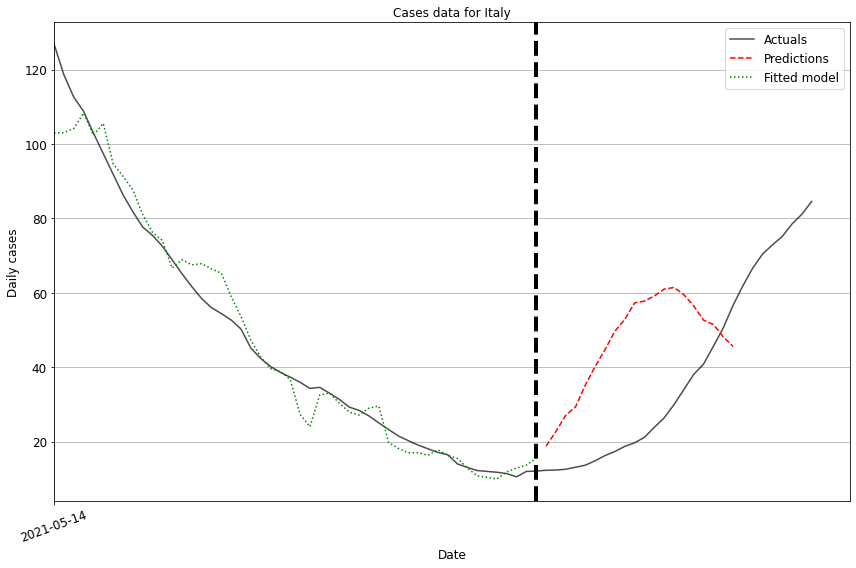

In [121]:
# Make "short prediction" after the discovery date
# delta here is the number of days after the discovery date for the target
# predicting the trend for 20 days
delta = 92
rscModel =syn_model(target, singVals, [data_df.iloc[delta:]], train_length + 20, train_length, otherStates=donors)
rscModel.fit_model(filter_donor = False, filter_method = 'percentile', singVals_estimate = True, singval_mathod ='auto')

predictions = rscModel.predictions
model_fit = rscModel.model_fit

fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()

print(rscModel.donors, rscModel.kSingularValues)

plt.show()

## HBO

outliers: ['Sweden' 'Portugal' 'Korea, South' 'Netherlands']
['France', 'Ireland', 'Germany', 'Denmark', 'Belgium', 'Sweden', 'Switzerland', 'Portugal', 'Norway', 'United Kingdom', 'Finland', 'Korea, South', 'Japan', 'Netherlands', 'Luxembourg', 'Austria', 'Slovenia', 'Russia', 'US', 'Spain', 'Czechia', 'Poland', 'Turkey'] 5


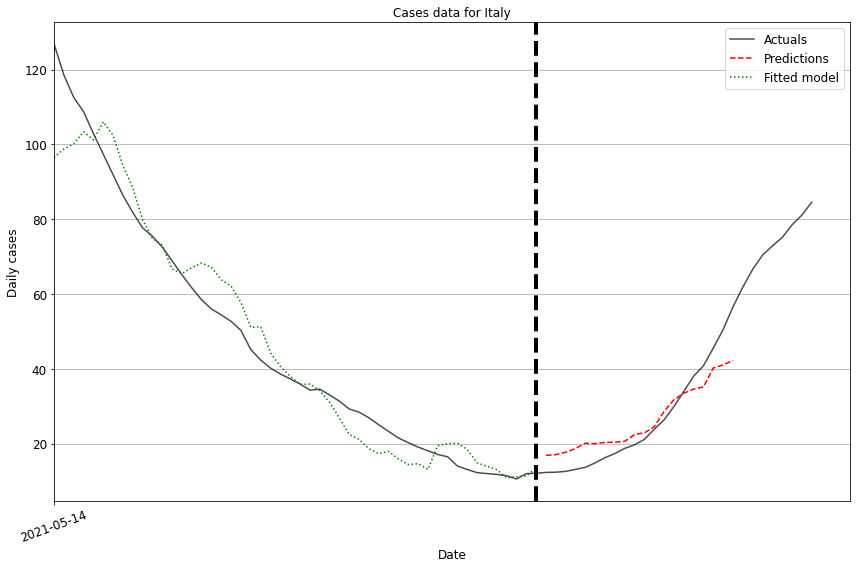

In [122]:

perm_dict = rscModel.permutation_distribution(show_graph = False, include_self = False, ri_method = 'ratio')
train_perm_dict = permutation_train_test(rscModel)
train_values = np.array(list(perm_dict.values()))

test_perm_dict = permutation_train_test(rscModel, train_err = False)
test_values = np.array(list(perm_dict.values()))

all_donors = np.array(list(perm_dict.keys()))
values = np.array(list(perm_dict.values()))

input_df =  pd.DataFrame([train_values,test_values]).transpose() # pd.DataFrame(values)
hbos = HBOS(alpha=0.1, contamination=0.15, n_bins=20, tol=0.5)
hbos.fit(input_df)
output = hbos.decision_function(input_df)
res = hbos.predict(input_df)
res = np.array(res, dtype = bool)

print('outliers:', all_donors[res])
# for item in all_donors[res]:
#     if item in outliers:
#         TP+=1
#     else:
#         FP+=1

################################################
################################################

rscModel2 =syn_model(target, singVals, [data_df.iloc[delta:]], train_length + 20, train_length, otherStates=list(all_donors[~res]))
try:
    rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
except Exception as e: 
    print(e)

fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel2.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()

print(rscModel.donors, rscModel.kSingularValues)

plt.show()

### Backward



target: Italy
donors: 23 removed: ['Netherlands']
training error before: 34.896844472420064 training error after: 47.68431274301737


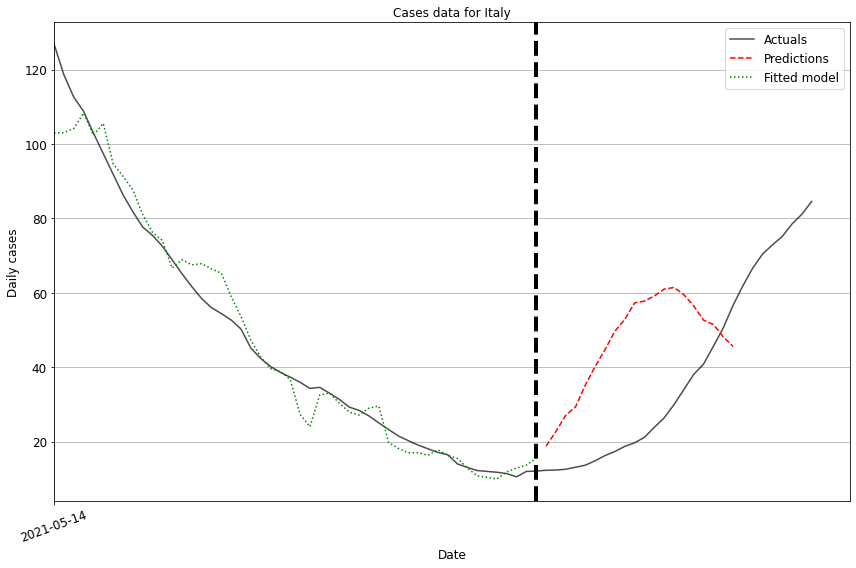

In [123]:
rscModel1 = rscModel
final_donors = rscModel1.donors
print('\n\ntarget:', target)
while len(final_donors)>3:
    #rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    #rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    #train_err1 = rscModel.train_err
    new_donors = backward_donor_elimination(rscModel1, metric=mean_squared_error, output = 'training_error')

    '''
    print(new_donors)
    rscModel1 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=final_donors)
    rscModel1.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    '''
    rscModel2 =syn_model(target, singVals, [data_df.iloc[delta:]], train_length + 20, train_length, otherStates=list(new_donors))
    #temp_model=syn_model(rscModel.state, rscModel.kSingularValues, rscModel.dfs, high_thresh, low_thresh, 
    #                    random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)

    rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')

    print('training error before:', rscModel1.train_err,'training error after:', rscModel2.train_err)
    if rscModel1.train_err <= rscModel2.train_err:
        break
    final_donors = new_donors
    rscModel1 = rscModel2
    
fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel1.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()


plt.show()

### Other analysis with the US counties

In [87]:
#plt.rcParams['figure.figsize'] = (24.0, 9.0)


lambdas = 1
high_thresh = 120
low_thresh = 30

model = syn_model(target, 7, [df], high_thresh, low_thresh, otherStates = group) #Create a syn_model object
model.fit_model(filter_donor = False, filter_method = 'iqr', ri_method = "diff", filter_metrics = mean_error)
print("Donors # %s"%(len(model.donors)))
print("Model train err %2.4f, Model test err %2.4f"%(model.train_err, model.test_err))


Donors # 6
Model train err 0.2316, Model test err 578.1750


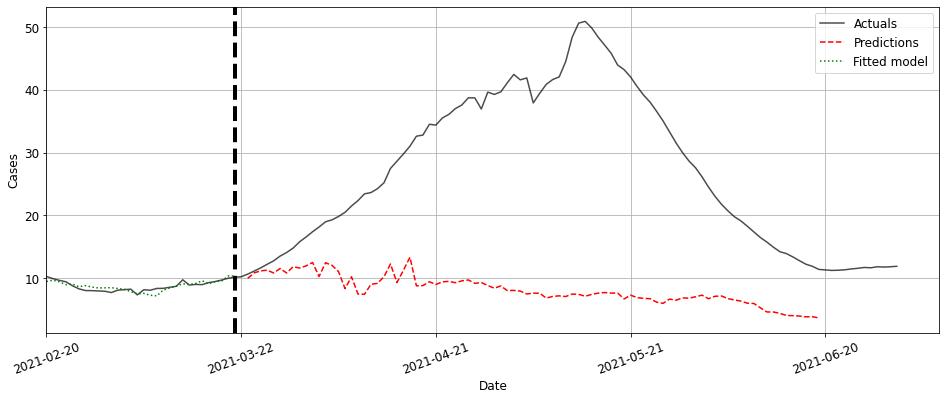

In [88]:
model.plot()

In [90]:
donor_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]

donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in donor_states and names[0] != 'Unknown':
        donors.append(counties)


In [157]:
df = all_cases_data_pop_daily
target = 'Japan'

singVals = 9

donor_start = "2021-03-01"
target_start = "2021-04-01"
prediction_length = 50
train_length = 50

donor_start_idx = list(df.index).index(donor_start) - train_length
donor_end_idx =  list(df.index).index(donor_start) + prediction_length

target_start_idx = list(df.index).index(target_start) - train_length
target_end_idx = list(df.index).index(target_start) + prediction_length

target_df = df[target][target_start_idx:target_end_idx]
donor_df = df[donors][donor_start_idx:donor_end_idx]
donor_df.index = target_df.index

df = pd.concat([target_df, donor_df], axis = 1)

#df = df[donors][donor_start_idx:donor_end_idx]



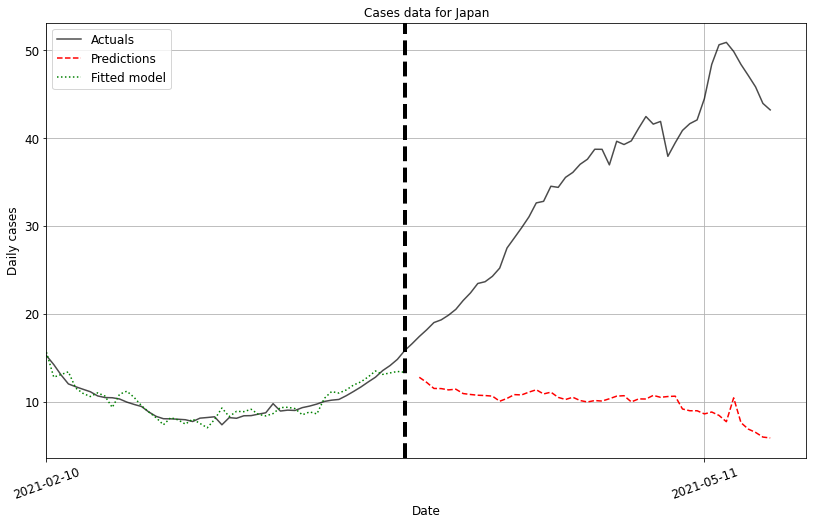

In [159]:
rscModel =syn_model(target, singVals, [df], train_length + prediction_length, train_length, otherStates=donors)
rscModel.fit_model(filter_donor = True, filter_method = 'percentile', singVals_estimate = False, singval_mathod ='auto')

predictions = rscModel.predictions
model_fit = rscModel.model_fit

fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()


plt.show()

In [139]:
print('donors = ',rscModel.donors, 'singvals:', rscModel.kSingularValues)
    

donors =  ['Addison-Vermont', 'Allegany-New York', 'Atlantic-New Jersey', 'Belknap-New Hampshire', 'Bennington-Vermont', 'Bristol-Massachusetts', 'Bristol-Rhode Island', 'Broome-New York', 'Burlington-New Jersey', 'Cape May-New Jersey', 'Carroll-New Hampshire', 'Cattaraugus-New York', 'Cayuga-New York', 'Chautauqua-New York', 'Chemung-New York', 'Chenango-New York', 'Cheshire-New Hampshire', 'Chittenden-Vermont', 'Clinton-New York', 'Columbia-New York', 'Cortland-New York', 'Cumberland-Maine', 'Cumberland-New Jersey', 'Delaware-New York', 'Dutchess-New York', 'Essex-Massachusetts', 'Essex-New Jersey', 'Essex-New York', 'Essex-Vermont', 'Fairfield-Connecticut', 'Franklin-Maine', 'Franklin-Massachusetts', 'Franklin-New York', 'Franklin-Vermont', 'Fulton-New York', 'Genesee-New York', 'Gloucester-New Jersey', 'Grafton-New Hampshire', 'Grand Isle-Vermont', 'Greene-New York', 'Hamilton-New York', 'Hampden-Massachusetts', 'Hancock-Maine', 'Hartford-Connecticut', 'Herkimer-New York', 'Hillsbo

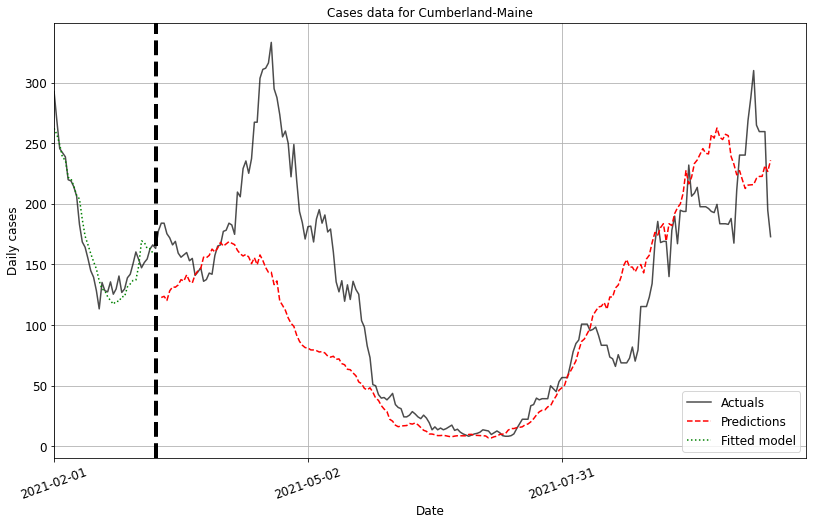

donors =  ['Addison-Vermont', 'Allegany-New York', 'Barnstable-Massachusetts', 'Bennington-Vermont', 'Carroll-New Hampshire', 'Cattaraugus-New York', 'Chenango-New York', 'Cheshire-New Hampshire', 'Chittenden-Vermont', 'Clinton-New York', 'Columbia-New York', 'Delaware-New York', 'Essex-New York', 'Essex-Vermont', 'Franklin-Maine', 'Franklin-Massachusetts', 'Franklin-New York', 'Franklin-Vermont', 'Fulton-New York', 'Grafton-New Hampshire', 'Greene-New York', 'Hamilton-New York', 'Hampshire-Massachusetts', 'Hunterdon-New Jersey', 'Litchfield-Connecticut', 'Livingston-New York', 'Madison-New York', 'Merrimack-New Hampshire', 'Middlesex-Connecticut', 'Newport-Rhode Island', 'Ontario-New York', 'Orleans-New York', 'Orleans-Vermont', 'Otsego-New York', 'Oxford-Maine', 'Rensselaer-New York', 'Rockingham-New Hampshire', 'Rutland-Vermont', 'Saratoga-New York', 'Schoharie-New York', 'Schuyler-New York', 'Seneca-New York', 'St. Lawrence-New York', 'Strafford-New Hampshire', 'Sullivan-New York',

In [95]:
#df = df[df.columns[(df>100).any()]].copy()
start_date = '2021-02-01'
low_thresh_date = '2021-03-10'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

i=1
for state in ['Cumberland-Maine']:
#otherStates = donors.copy()
    ''''''
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])

    
    
    if state in otherStates:
        otherStates.remove(state)
        
    
    # Adding outliers:
    for item in ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']:
        otherStates.append(item)
    
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit_model(filter_donor = True, filter_method = 'quantile', singVals_estimate = True, singval_mathod ='auto')
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
     
    fig, axes = plt.subplots(1, 1, figsize = (12, 8))

    rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
    #plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
    plt.tight_layout()
    

    plt.show()

    print('donors = ',rscModel.donors, 'singvals:', rscModel.kSingularValues)
    

## Omicron Variant in the U.S.

In [10]:
'''
delta_variant_data_US =    {'Alabama': '2021-07-01',
                            'Alaska':'2021-05-25',
                            'Arizona': '2021-05-05', # https://www.azmirror.com/2021/07/09/deadly-delta-variant-of-covid-19-is-spreading-rapidly-in-arizona/
                            # 'Arkansas': '2021-12-17',
                            'California': '2021-06-22', # https://abc30.com/delta-variant-tulare-county-covid/10828966/
                            'Colorado': '2021-05-05', # https://www.cdc.gov/mmwr/volumes/70/wr/mm7032e2.htm
                            'Connecticut': '2021-05-05', # https://www.nbcconnecticut.com/news/coronavirus/conn-experts-say-to-be-cautious-of-the-covid-19-delta-variant/2508276/
                            # 'Delaware': '2021-12-17',
                            'Florida': '2021-12-07',
                            'Georgia': '2021-12-03',
                            'Hawaii': '2021-12-02',
                            'Idaho': '2021-12-10',
                            'Illinois': '2021-12-07',
                            'Indiana': '2021-12-19',
                            'Iowa': '2021-12-09',
                            'Kansas': '2021-12-16',
                            'Louisiana': '2021-12-03',
                            'Maine': '2021-12-17',
                            'Maryland': '2021-12-03',
                            'Massachusetts': '2021-12-04',
                            'Michigan': '2021-12-09',
                            'Minnesota': '2021-12-02',
                            'Mississippi': '2021-12-06',
                            'Missouri': '2021-12-03',
                            #'Montana': '2021-12-20',
                            'Nebraska': '2021-12-03',
                            'New Hampshire': '2021-12-13',
                            'New Jersey': '2021-12-03', #https://www.inquirer.com/news/omicron-first-new-jersey-case-gov-murphy-20211204.html
                            'New Mexico': '2021-12-13', 
                            'Nevada':'2021-12-13', 
                            'New York': '2021-12-02',
                            'North Carolina': '2021-12-10',
                            'North Dakota': '2021-12-19',
                            'Ohio':  '2021-12-10',
                            #'Oklahoma': '2021-12-21',
                            'Oregon': '2021-12-13',
                            'Pennsylvania': '2021-12-03',
                            'Rhode Island':'2021-12-11',
                            'South Carolina': '2021-12-15',
                            #'South Dakota': '2021-12-22',
                            'Tennessee': '2021-12-11',
                            'Texas': '2021-12-06', # https://www.kxan.com/news/texas/texas-announces-first-detected-case-of-omicron-variant-in-harris-county/
                            'Utah': '2021-12-03',
                            'Vermont':'2021-12-18',
                            'Virginia': '2021-12-09',
                            'Wisconsin': '2021-12-04',
                            'Washington': '2021-12-04',
                            #'Washington, D.C': '2021-12-12',
                            'West Virginia':'2021-12-16',
                            'Wyoming':'2021-12-17',
                     }
delta_variant_data_US = pd.DataFrame(delta_variant_data_US, index = ["Date"]).T

'''



'\ndelta_variant_data_US =    {\'Alabama\': \'2021-07-01\',\n                            \'Alaska\':\'2021-05-25\',\n                            \'Arizona\': \'2021-05-05\', # https://www.azmirror.com/2021/07/09/deadly-delta-variant-of-covid-19-is-spreading-rapidly-in-arizona/\n                            # \'Arkansas\': \'2021-12-17\',\n                            \'California\': \'2021-06-22\', # https://abc30.com/delta-variant-tulare-county-covid/10828966/\n                            \'Colorado\': \'2021-05-05\', # https://www.cdc.gov/mmwr/volumes/70/wr/mm7032e2.htm\n                            \'Connecticut\': \'2021-05-05\', # https://www.nbcconnecticut.com/news/coronavirus/conn-experts-say-to-be-cautious-of-the-covid-19-delta-variant/2508276/\n                            # \'Delaware\': \'2021-12-17\',\n                            \'Florida\': \'2021-12-07\',\n                            \'Georgia\': \'2021-12-03\',\n                            \'Hawaii\': \'2021-12-02\',\n     

In [7]:
# source : https://www.nbcchicago.com/news/local/the-omicron-variant-is-confirmed-in-16-us-states-heres-where-and-what-we-know-about-each-case/2700769/
# https://www.beckershospitalreview.com/public-health/states-where-the-omicron-variant-has-been-detected.html
omincron_variant_data_US = {'Alabama': '2021-12-16',
                            'Alaska':'2021-12-13',
                            'Arizona': '2021-12-08',
                            'Arkansas': '2021-12-17',
                            'California': '2021-12-01',
                            'Colorado': '2021-12-02',
                            'Connecticut': '2021-12-04',
                            'Delaware': '2021-12-17',
                            'Florida': '2021-12-07',
                            'Georgia': '2021-12-03',
                            'Hawaii': '2021-12-02',
                            'Idaho': '2021-12-10',
                            'Illinois': '2021-12-07',
                            'Indiana': '2021-12-19',
                            'Iowa': '2021-12-09',
                            'Kansas': '2021-12-16',
                            'Louisiana': '2021-12-03',
                            'Maine': '2021-12-17',
                            'Maryland': '2021-12-03',
                            'Massachusetts': '2021-12-04',
                            'Michigan': '2021-12-09',
                            'Minnesota': '2021-12-02',
                            'Mississippi': '2021-12-06',
                            'Missouri': '2021-12-03',
                            #'Montana': '2021-12-20',
                            'Nebraska': '2021-12-03',
                            'New Hampshire': '2021-12-13',
                            'New Jersey': '2021-12-03', #https://www.inquirer.com/news/omicron-first-new-jersey-case-gov-murphy-20211204.html
                            'New Mexico': '2021-12-13', 
                            'Nevada':'2021-12-13', 
                            'New York': '2021-12-02',
                            'North Carolina': '2021-12-10',
                            'North Dakota': '2021-12-19',
                            'Ohio':  '2021-12-10',
                            #'Oklahoma': '2021-12-21',
                            'Oregon': '2021-12-13',
                            'Pennsylvania': '2021-12-03',
                            'Rhode Island':'2021-12-11',
                            'South Carolina': '2021-12-15',
                            #'South Dakota': '2021-12-22',
                            'Tennessee': '2021-12-11',
                            'Texas': '2021-12-06', # https://www.kxan.com/news/texas/texas-announces-first-detected-case-of-omicron-variant-in-harris-county/
                            'Utah': '2021-12-03',
                            'Vermont':'2021-12-18',
                            'Virginia': '2021-12-09',
                            'Wisconsin': '2021-12-04',
                            'Washington': '2021-12-04',
                            #'Washington, D.C': '2021-12-12',
                            'West Virginia':'2021-12-16',
                            'Wyoming':'2021-12-17',
                     }
omincron_variant_data_US = pd.DataFrame(omincron_variant_data_US, index = ["Date"]).T


In [8]:

## Align the data set by discovery date of delta
df = all_cases_data_pop_daily

target = "Vermont"
target_start = omincron_variant_data_US.loc[target].values[0]
tick_spacing = 90
filter_donor_by_date = True
singVals = 6


## Use the county with delta discovery date earlier than target
if filter_donor_by_date:

    donors = list(omincron_variant_data_US.loc[omincron_variant_data_US['Date'] < target_start].index)
    
else:
    
    donors = list(omincron_variant_data_US.index)
    donors.remove(target)

donor_start = omincron_variant_data_US.loc[donors].values.flatten()

prediction_length = 120

train_length = 50

donor_start_idx = [list(df.index).index(date) - train_length for date in donor_start]
donor_end_idx =  [list(df.index).index(date) + prediction_length for date in donor_start]

target_start_idx = list(df.index).index(target_start) - train_length
target_end_idx = list(df.index).index(target_start) + prediction_length

data_df = df[target][target_start_idx:target_end_idx]
idx = data_df.index
data_df = pd.Series(data_df.values, name = target)
#print(data_df.shape)

for i in range(len(donors)):
    temp_df = df[donors[i]][donor_start_idx[i]:donor_end_idx[i]]
    data_df = pd.concat([data_df, pd.Series(temp_df.values, name = donors[i])], axis = 1)

data_df = data_df[:len(idx)]
data_df.index = idx



['Alabama', 'Alaska', 'Arizona', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Georgia', 'Idaho', 'Illinois', 'Iowa', 'Kansas', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico', 'Nevada', 'New York', 'North Carolina', 'Ohio', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Wisconsin', 'Washington', 'West Virginia', 'Wyoming'] 3


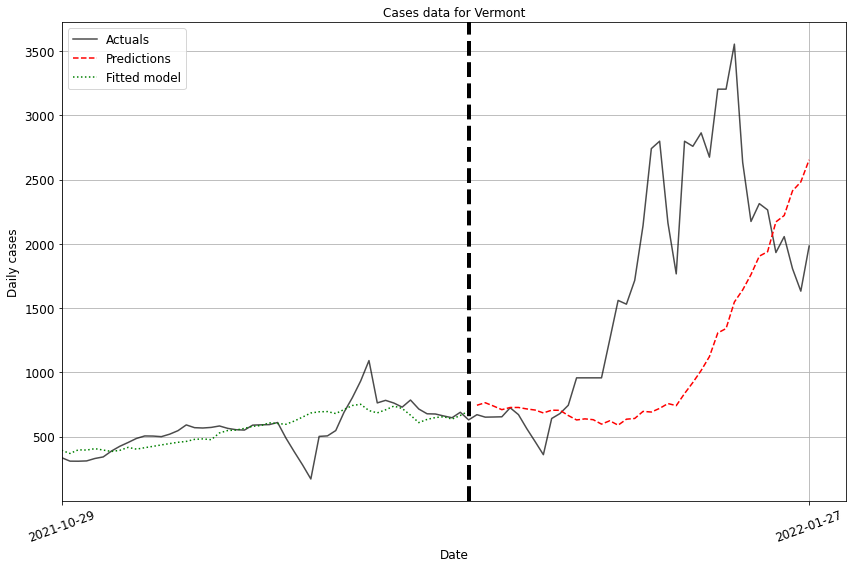

In [9]:
# sc model using the discovery date as intervention date
rscModel =syn_model(target, singVals, [data_df], train_length + prediction_length, train_length, otherStates=donors)
rscModel.fit_model(filter_donor = True, filter_method = 'hbo', singVals_estimate = True, singval_mathod ='auto')

predictions = rscModel.predictions
model_fit = rscModel.model_fit

fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()

print(rscModel.donors, rscModel.kSingularValues)

plt.show()


outliers: ['Arkansas' 'Florida' 'Hawaii' 'Louisiana' 'Maryland' 'New Jersey'
 'South Carolina']


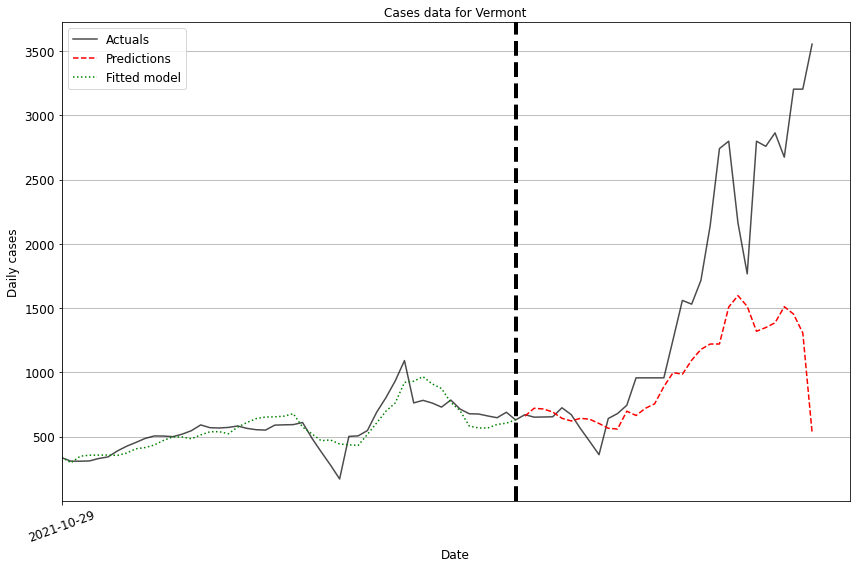

In [14]:
perm_dict = rscModel.permutation_distribution(show_graph = False, include_self = False, ri_method = 'ratio')
train_perm_dict = permutation_train_test(rscModel)
train_values = np.array(list(perm_dict.values()))

test_perm_dict = permutation_train_test(rscModel, train_err = False)
test_values = np.array(list(perm_dict.values()))

all_donors = np.array(list(perm_dict.keys()))
values = np.array(list(perm_dict.values()))

input_df =  pd.DataFrame([train_values,test_values]).transpose() # pd.DataFrame(values)
hbos = HBOS(alpha=0.1, contamination=0.15, n_bins=20, tol=0.5)
hbos.fit(input_df)
output = hbos.decision_function(input_df)
res = hbos.predict(input_df)
res = np.array(res, dtype = bool)

print('outliers:', all_donors[res])
# for item in all_donors[res]:
#     if item in outliers:
#         TP+=1
#     else:
#         FP+=1

################################################
################################################

rscModel2 =syn_model(target, singVals, [data_df], train_length + prediction_length, train_length, otherStates=list(all_donors[~res]))
try:
    rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
except Exception as e: 
    print(e)

fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel2.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()

plt.show()


In [23]:
train_length

50

['Alaska', 'Arizona', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Georgia', 'Idaho', 'Illinois', 'Iowa', 'Louisiana', 'Maine', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico', 'Nevada', 'New York', 'North Carolina', 'Ohio', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Wisconsin', 'Washington', 'West Virginia', 'Wyoming'] 7


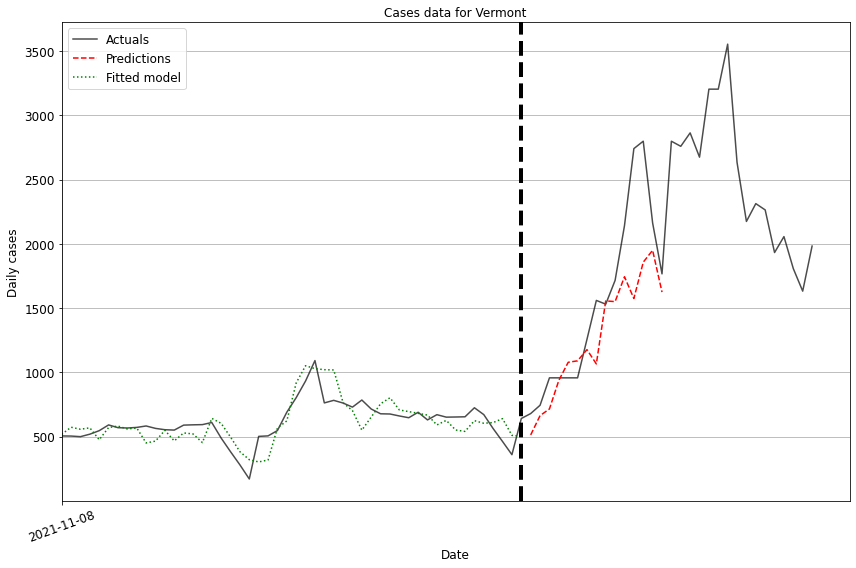

In [12]:
# Make "short prediction" after the discovery date
# delta here is the number of days after the discovery date for the target
# predicting the trend for 20 days
delta = 10
rscModel =syn_model(target, singVals, [data_df.iloc[delta:]], train_length + 15, train_length, otherStates=donors)
rscModel.fit_model(filter_donor = True, filter_method = 'hbo', singVals_estimate = True, singval_mathod ='auto')

predictions = rscModel.predictions
model_fit = rscModel.model_fit

fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()

print(rscModel.donors, rscModel.kSingularValues)

plt.show()